In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier as NN

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from tqdm import tqdm
from scipy.sparse import csr_matrix, csgraph

import numba
from numba import jit
from multiprocessing import Pool
from joblib import Parallel
import math
import os

In [2]:
import dill
# to save the current session, uncomment the next line
# dill.dump_session("mnist_graph_construction.db")

# Load the previous session
# dill.load_session("utils/mnist_graph_construction.db")


In [3]:
# import pickle
# # Store individual objects (save them in sequential order)
# with open("inter_data.pickle", "wb") as inter_data_file:
#     pickle.dump(X, inter_data_file)
#     pickle.dump(y, inter_data_file)

# # Load individual objects (the order is the same as how they are stored)
# with open("inter_data.pickle", "rb") as inter_data_file:
#     pickled_X = pickle.load(inter_data_file)
#     pickled_y = pickle.load(inter_data_file)

In [4]:
# Load the dataset
# https://www.python-course.eu/neural_network_mnist.php
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "mnist_data/mnist_train.csv"
# train_data = np.loadtxt(data_path, delimiter=",")
# fac = 0.99 / 255
# train_imgs = np.asfarray(train_data[:, 1:]) * fac + 0.01
# train_ilabels = np.asfarray(train_data[:, :1]).ravel()

train_data = pd.read_csv(data_path, 
                        delimiter=",", header=None, dtype=np.uint8)
train_imgs = train_data.iloc[:, 1:]/255   # divide by 255 only for model prediction
train_imgs = train_imgs.astype("float32")
# train_imgs = train_data.iloc[:, 1:]
train_labels = np.asarray(train_data.iloc[:, :1][0])


In [5]:
# subsample the original dataset, each digit has 1000 instances rather than 5000-6000

all_indices = []
# for digit in [0, 1, 2, 4, 7, 8, 9]:
for digit in np.arange(0,10):
    single_digit_indices = set(np.where(train_labels == digit)[0][:1000])
    all_indices = set(all_indices).union(single_digit_indices)
print(len(all_indices))

X = train_imgs.iloc[list(all_indices), :]
y = train_labels[list(all_indices)]


10000


In [6]:

import os
from joblib import Parallel, delayed
@jit(nopython=True)
def calculate_weighted_distance(v0, v1, penalty_term = 2):
    diff = np.subtract(v0, v1)
    reweight_vector = np.where(diff>=0, 1, -penalty_term)
    weighted_diff = np.linalg.norm(diff*reweight_vector)
    return weighted_diff

def get_weights_kNN(
    X, 
    n_neighbours = 20,
    penalty_term = 2,
    weight_func = None
    ):
    n_samples, n_ftrs = X.shape
    
    k = np.zeros((n_samples, n_samples))
    W = k
    X = X.to_numpy()

    for i in tqdm(range(n_samples)):
        v0 = X[i]
        for j in range(n_samples):
            v1 = X[j]
            # modify the distance function so that removing pixels incurring larger cost.
            dist = calculate_weighted_distance(v1, v0, penalty_term=penalty_term)
            # dist = np.linalg.norm(v0 - v1)
            k[i, j] = dist
            if dist != 0:
                W[i,j] = weight_func(dist)
        
        t = np.argsort(k[i, :])[(n_neighbours+1):]
        mask = np.ix_(t)
        k[i, mask] = 0
        W[i, mask] = 0
        
    return W


def get_weights_kNN_multi(
    X,
    n_neighbours=20,
    penalty_term=2,
    weight_func=None,
    n_jobs=os.cpu_count()  # Number of processors
):
    n_samples, n_ftrs = X.shape
    k = np.zeros((n_samples, n_samples))
    W = k
    X_np = X.to_numpy()

    def process_row(i):
        v0 = X_np[i]
        row_k = np.zeros(n_samples)
        row_W = np.zeros(n_samples)
        for j in range(n_samples):
            v1 = X_np[j]
            dist = calculate_weighted_distance(
                v1, v0, penalty_term=penalty_term)
            row_k[j] = dist
            if dist != 0:
                row_W[j] = weight_func(dist)
        t = np.argsort(row_k)[(n_neighbours+1):]
        row_k[t] = 0
        row_W[t] = 0
        return row_k, row_W

    results = Parallel(n_jobs=n_jobs)(delayed(process_row)(i)
                                      for i in tqdm(range(n_samples)))
    for i, (row_k, row_W) in enumerate(results):
        k[i, :] = row_k
        W[i, :] = row_W

    return W

In [7]:
clf = NN(max_iter=5000).fit(X, y)

In [8]:
predictions = clf.predict_proba(X)

In [9]:
def construct_graph(weight_matrix):
    graph = csr_matrix(weight_matrix)
    return graph

def find_shortest_path(graph, start_point_idx):
    dist_matrix, predecessors = csgraph.dijkstra(
        csgraph=graph, directed=True, indices=start_point_idx, return_predecessors=True
    )
    return dist_matrix, predecessors

def reconstruct_shortest_path(predecessors, start_point_idx, end_point_idx):
    """Get all the nodes along the path between the start point and the end point. 

    Args:
        predecessors (matrix of shape (1, n_nodes)): contain the previous node in the path.
        start_point_idx (int): the index of the start data point
        end_point_idx (int): the index of the end data point

    Returns:
        node_path (list): [start_point_idx, intermedium points index, end_point_idx]
    """
    if predecessors[end_point_idx] == start_point_idx:
        node_path = [end_point_idx]
    else:
        node_path = []
    intermedium_idx = end_point_idx
    while (predecessors[intermedium_idx] != start_point_idx):
        node_path.append(intermedium_idx)
        intermedium_idx = predecessors[intermedium_idx]
    if intermedium_idx != node_path[-1]:
        node_path.append(intermedium_idx)
    node_path.append(start_point_idx)
    
    return node_path[::-1]
 
def build_symmetric_matrix(kernel):
    for i in range(kernel.shape[0]):
        for j in range(i):
            kernel[j, i] = kernel[i,j]
    return kernel

def build_asymmetric_matrix(kernel, X, weight_func, penalty_term):
    n_samples = kernel.shape[0]
    X = X.to_numpy()
    for i in tqdm(range(n_samples)):
        for j in range(n_samples):
            if kernel[i,j] != 0:
                v0 = X[i]
                v1 = X[j]
                dist = calculate_weighted_distance(v0, v1, penalty_term=penalty_term)
                kernel[j, i] = weight_func(dist)
    return kernel

In [10]:
n_neighbours = 20
penalty_term = 1.1
n_samples, n_features = X.shape

def get_volume_of_sphere(d):
    return math.pi**(d/2)/math.gamma(d/2 + 1)

volume_sphere = get_volume_of_sphere(1)
r = (n_neighbours / (n_samples * volume_sphere))

# Construct the global weighted graph.
# Kernel is asymmetric if using KNN to get weight, and OG only keeps the bottom left half of the matrix
weight_func=lambda x: -x*np.log(r/x)  # x**alpha

# kernel_single = get_weights_kNN(
#             X,
#             penalty_term=penalty_term,
#             n_neighbours=int(n_neighbours),
#             weight_func=weight_func
#         )

kernel = get_weights_kNN_multi(
            X,
            penalty_term=penalty_term,
            n_neighbours=int(n_neighbours),
            weight_func=weight_func
        )

# sym_kernel = build_symmetric_matrix(kernel)
# asym_kernel = build_asymmetric_matrix(kernel, X, weight_func)

# Replace FOR with parallel FOR (multi-processors emia..)
# On local laptop, set the number of processors to 2
# On server, set the number of processors to #of available - 1 

# verify that the two kernels are the same
# print(np.allclose(kernel, kernel_single))
# print(np.array_equal(kernel, kernel_single))

100%|██████████| 10000/10000 [01:00<00:00, 165.45it/s]


In [11]:
asym_kernel = build_asymmetric_matrix(kernel, X, weight_func, penalty_term)

# dill.dump_session("mnist_graph_construction.db")

100%|██████████| 10000/10000 [00:11<00:00, 905.94it/s]


In [12]:
def get_minimum_dist(dist_matrix):
    """get the shortest distance and its data index
    Args:
        dist_matrix (array): shape: 1 x n_nodes

    Returns:
        min_dist: minimum distance in the distance matrix
        min_dist_idx: index of the data point with the shortest dist
    """
    min_dist = np.min(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False)) 
    min_dist_idx = np.argmin(np.ma.masked_where(dist_matrix==0, dist_matrix, copy=False))
    return min_dist, min_dist_idx

def get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths = 1, pred_threshold=0.55):
    assert num_paths > 0 and isinstance(num_paths, int), "only positive integers"
    end_point_idx = []
    path_count = 0
    for idx in np.argsort(np.ma.masked_where(dist_matrix==0, dist_matrix)):
        if (y[idx] == target_class and
        predictions[idx, class_labels.index(target_class)] >= pred_threshold): 
            end_point_idx.append(idx)
            if path_count >= num_paths-1:
                break
            else:
                path_count += 1
    return end_point_idx

def get_user_agency(sp_graph, start_point_idx, alternative_classes, predictions, y, class_labels, pred_threshold=0.55):
    dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx)
    alt_class_dict = {}
    alt_path_dict = {}
    for alt_class in alternative_classes:
        alt_end_idx = get_closest_cf_point(dist_matrix, predictions, y, alt_class, class_labels, pred_threshold = pred_threshold)
        alt_end_dist = dist_matrix[alt_end_idx[0]]
        alt_class_dict[alt_class] = {alt_end_idx[0]: alt_end_dist}
        
        alt_end_path = reconstruct_shortest_path(predecessors, start_point_idx, alt_end_idx[0])
        alt_path_dict[alt_class] = {alt_end_idx[0]: alt_end_path}
    
    return alt_class_dict, alt_path_dict

In [13]:
np.where(y==7)[0][41:60]

array([387, 411, 422, 426, 436, 446, 467, 468, 478, 483, 497, 505, 511,
       518, 521, 522, 560, 562, 567])

In [14]:
# [7->2] 728, 1614
# [7->4] 728, 7770, 7350
# [7->3] 728, 8012
# [7->5] 728, 1088, 778
# [7->6] 728, 5650, 1031, 9676 
# [7->8] 728, 3003

In [15]:
sp_graph = construct_graph(kernel)
start_point_idx = 728
target_class = 8
class_labels = list(map(int, clf.classes_))
alternative_classes = list(set(class_labels) - set([target_class, y[start_point_idx]]))
res = {}
res[start_point_idx] = {}

dist_matrix, predecessors = find_shortest_path(sp_graph, start_point_idx=start_point_idx)

end_point_indices = get_closest_cf_point(dist_matrix, predictions, y, target_class, class_labels, num_paths=10)
print(end_point_indices)

for order, end_point_idx in enumerate(end_point_indices):
    shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=end_point_idx)
    flag = 0
    for node_idx in shortest_path[:-1]:
        # print(np.argmax(predictions[node_idx]))
        if np.argmax(predictions[node_idx]) not in [1, target_class]:
            flag = 1
        alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
        # alt_class_dict, alt_path_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
        # print("node index: ", node_idx)
        # print(alt_class_dict)
    # if flag == 1:
        res[start_point_idx][order] = shortest_path
print(res)

[np.int64(3002), np.int64(6534), np.int64(1434), np.int64(4006), np.int64(9141), np.int64(8175), np.int64(3570), np.int64(6498), np.int64(9516), np.int64(5338)]
{728: {0: [728, np.int64(3002)], 1: [728, np.int32(8123), np.int64(6534)], 2: [728, np.int32(3193), np.int64(1434)], 3: [728, np.int32(2844), np.int64(4006)], 4: [728, np.int32(5650), np.int64(9141)], 5: [728, np.int32(3193), np.int64(8175)], 6: [728, np.int32(5976), np.int64(3570)], 7: [728, np.int32(5650), np.int64(6498)], 8: [728, np.int32(1088), np.int64(9516)], 9: [728, np.int32(2844), np.int64(5338)]}}


In [16]:
# dill.dump_session("mnist_graph_construction.db")

In [17]:
def plot_digits(path, _id):
    n_digits = len(path)
    ncols=min(10, n_digits)
    nrows = math.ceil(n_digits / ncols)
    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))
    axes = axes.ravel()
    for idx, img_idx in enumerate(path):
        ax = axes[idx]
        image = np.array(X.iloc[img_idx, :])
        label = y[img_idx]
        ax.set_axis_off()
        ax.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title(f"id:{_id}, t: {label}")
    # plt.savefig(f'example_{_id}_log.pdf', dpi=300)

def print_alt_paths(alt_path_dict):
    for alt_class, alt_class_path in alt_path_dict.items():
        plot_digits(list(alt_class_path.items())[0][1], '-'.join(map(str, [alt_class, 0])))

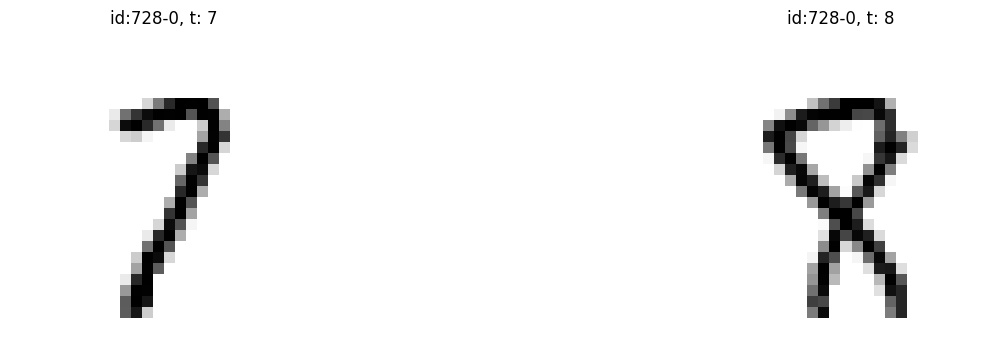

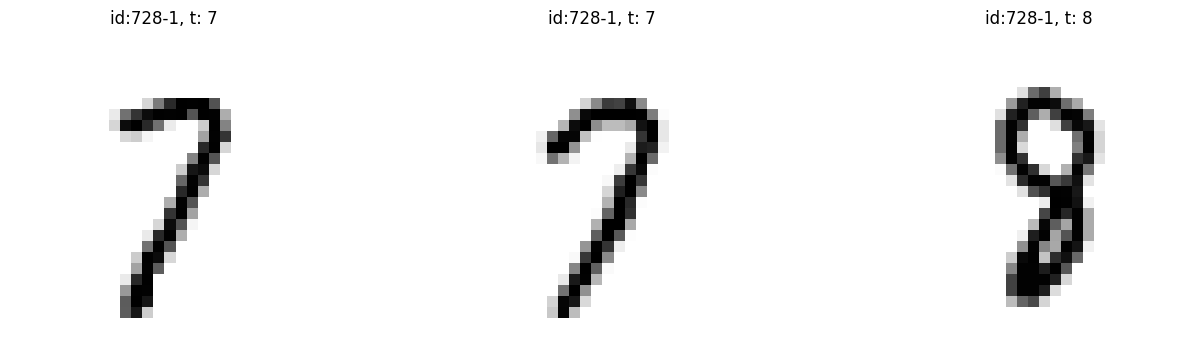

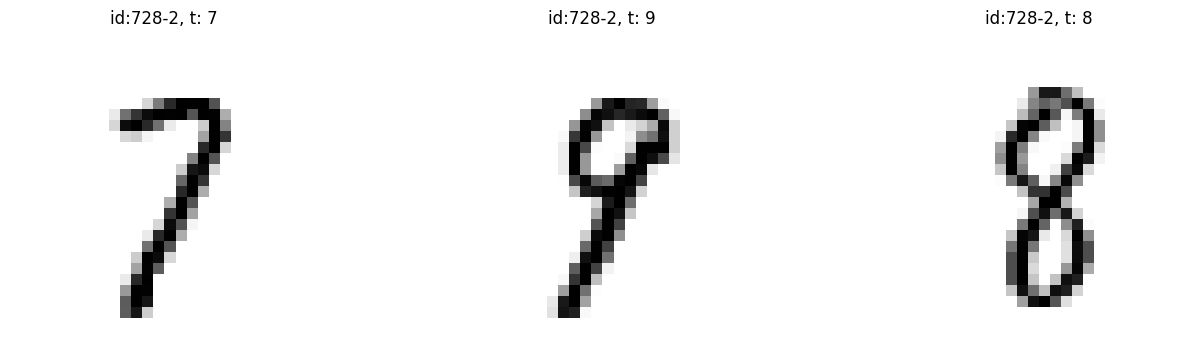

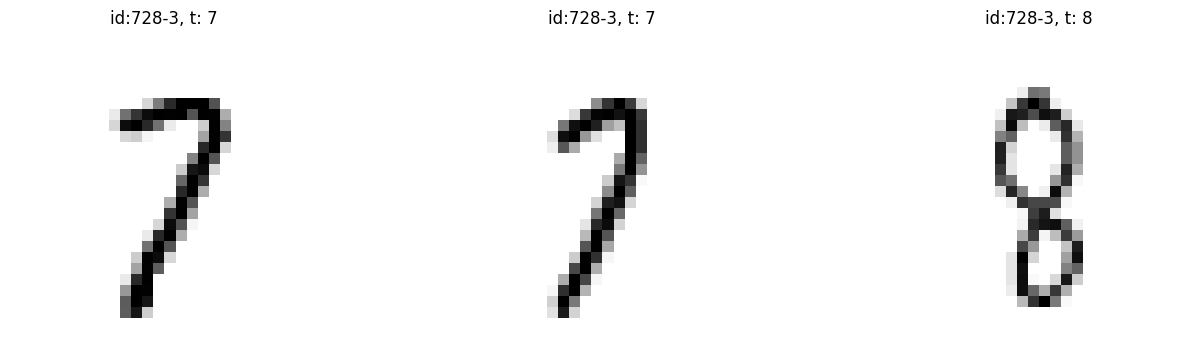

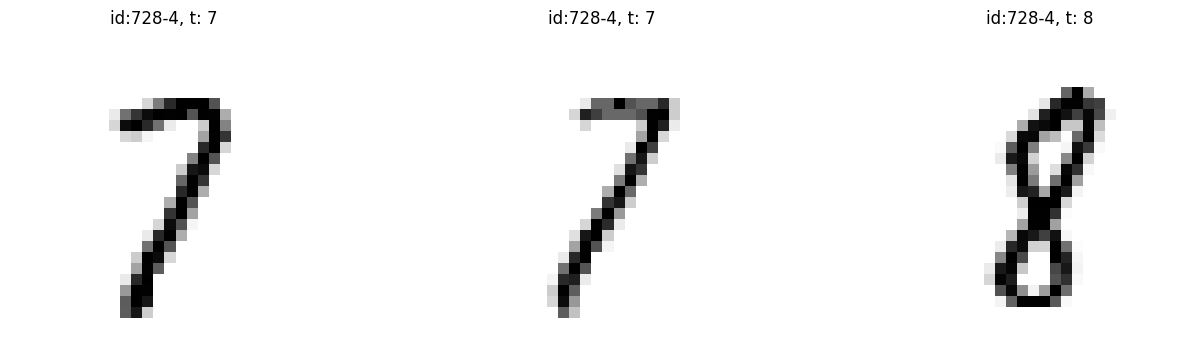

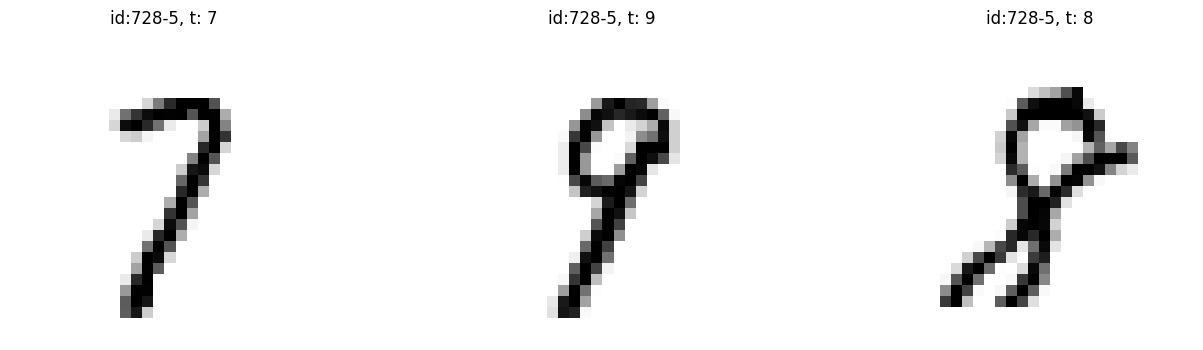

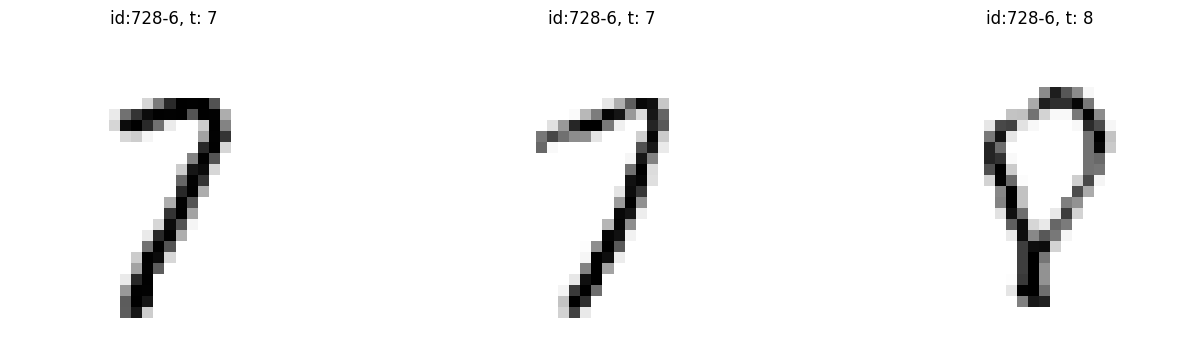

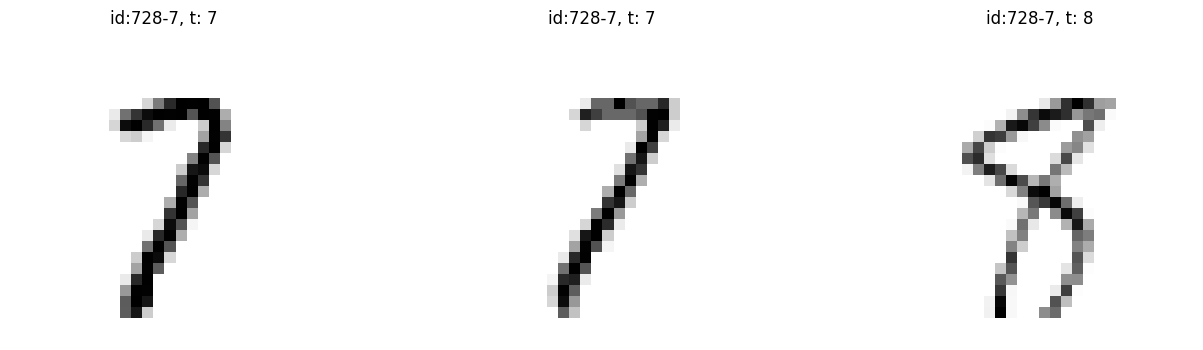

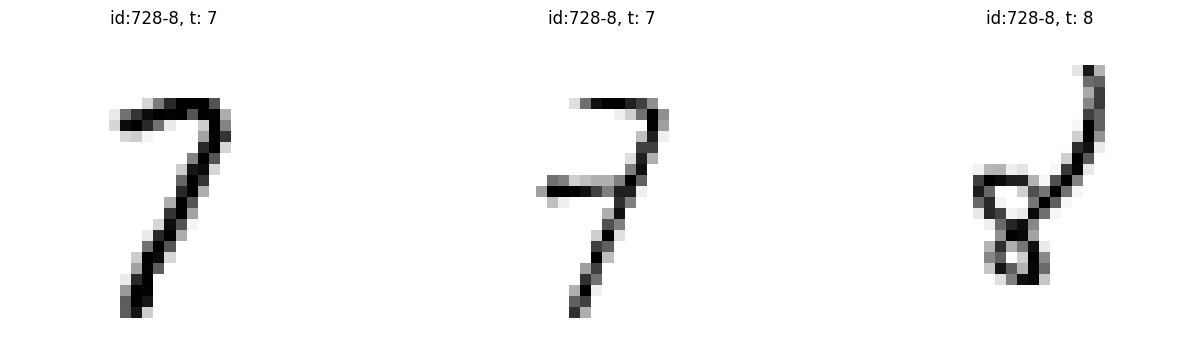

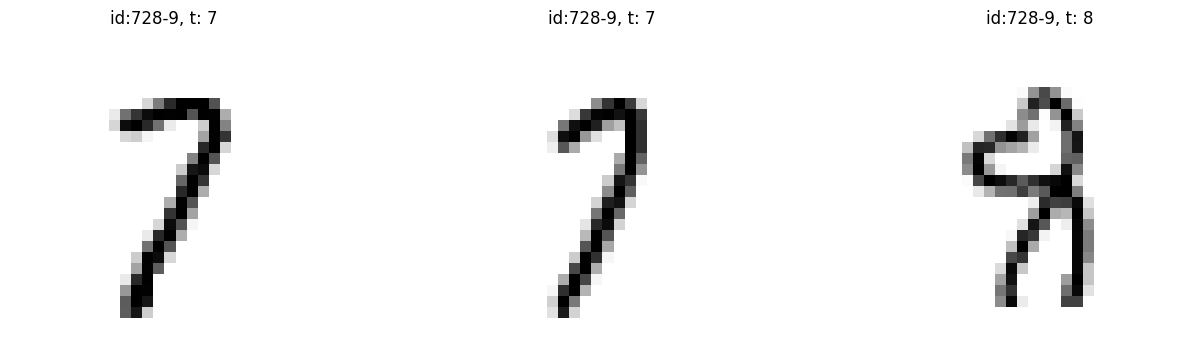

In [18]:
for k in res.keys():
    for k2 in res[k].keys():
        plot_digits(res[k][k2], '-'.join(map(str, [k, k2])))


node index:  728
{0: {np.int64(5196): np.float64(121.67227754761558)}, 1: {np.int64(1031): np.float64(67.76016076200872)}, 2: {np.int64(1614): np.float64(50.8229248532451)}, 3: {np.int64(8012): np.float64(46.559723438708744)}, 4: {np.int64(7350): np.float64(66.63645314635562)}, 5: {np.int64(778): np.float64(99.93082202136591)}, 6: {np.int64(9676): np.float64(134.40133523731566)}, 9: {np.int64(3193): np.float64(35.905077975201735)}}
{0: {np.int64(5196): [728, np.int32(1614), np.int64(5196)]}, 1: {np.int64(1031): [728, np.int32(5650), np.int64(1031)]}, 2: {np.int64(1614): [728, np.int64(1614)]}, 3: {np.int64(8012): [728, np.int64(8012)]}, 4: {np.int64(7350): [728, np.int32(7770), np.int64(7350)]}, 5: {np.int64(778): [728, np.int32(1088), np.int64(778)]}, 6: {np.int64(9676): [728, np.int32(5650), np.int32(1031), np.int64(9676)]}, 9: {np.int64(3193): [728, np.int64(3193)]}}
node index:  3408
{0: {np.int64(1512): np.float64(146.597080123149)}, 1: {np.int64(1044): np.float64(38.7452907668468

/tmp/ipykernel_8246/1967381332.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))


node index:  3756
{0: {np.int64(1137): np.float64(65.06170754377403)}, 1: {np.int64(3703): np.float64(168.67917810471874)}, 2: {np.int64(9096): np.float64(126.96324353988172)}, 4: {np.int64(7487): np.float64(175.58885757036222)}, 5: {np.int64(2966): np.float64(69.3438833674293)}, 6: {np.int64(5780): np.float64(180.0398122150371)}, 7: {np.int64(2014): np.float64(137.2941105825469)}, 9: {np.int64(346): np.float64(117.99945020546116)}}
{0: {np.int64(1137): [np.int32(3756), np.int64(1137)]}, 1: {np.int64(3703): [np.int32(3756), np.int32(4262), np.int32(2580), np.int64(3703)]}, 2: {np.int64(9096): [np.int32(3756), np.int32(8159), np.int64(9096)]}, 4: {np.int64(7487): [np.int32(3756), np.int32(4262), np.int32(7832), np.int64(7487)]}, 5: {np.int64(2966): [np.int32(3756), np.int64(2966)]}, 6: {np.int64(5780): [np.int32(3756), np.int32(4262), np.int32(8213), np.int64(5780)]}, 7: {np.int64(2014): [np.int32(3756), np.int32(5690), np.int64(2014)]}, 9: {np.int64(346): [np.int32(3756), np.int32(6497

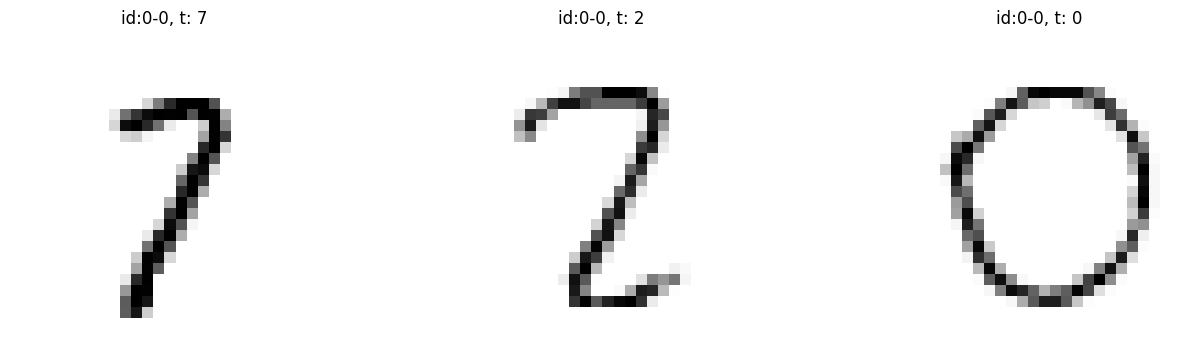

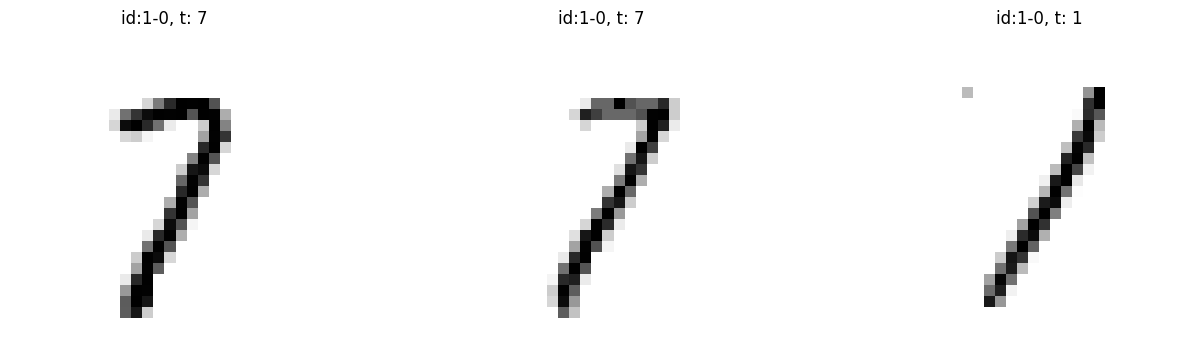

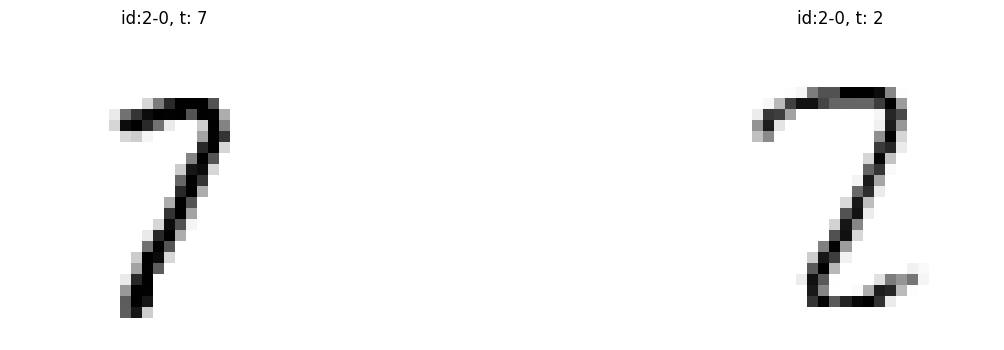

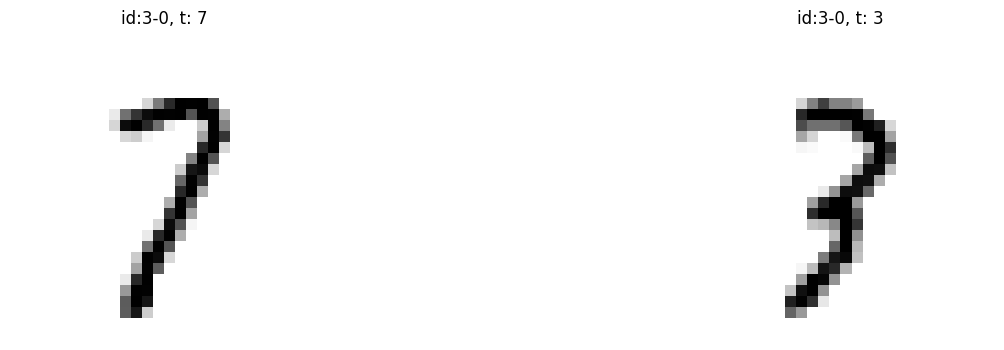

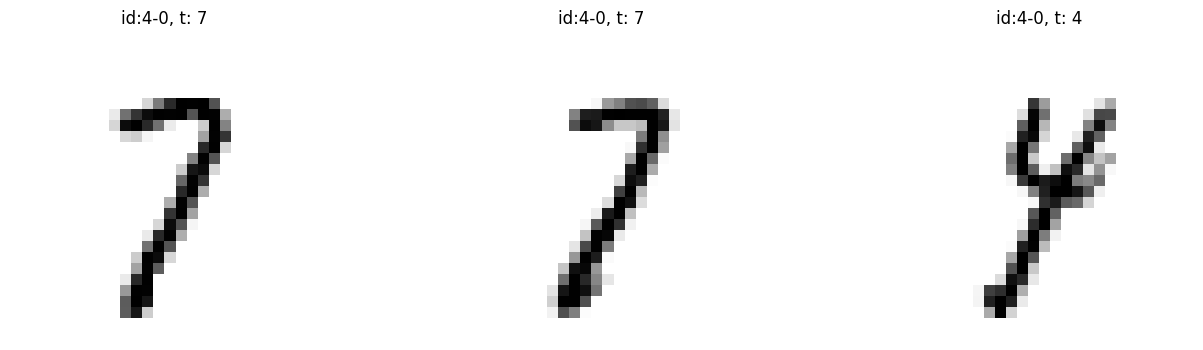

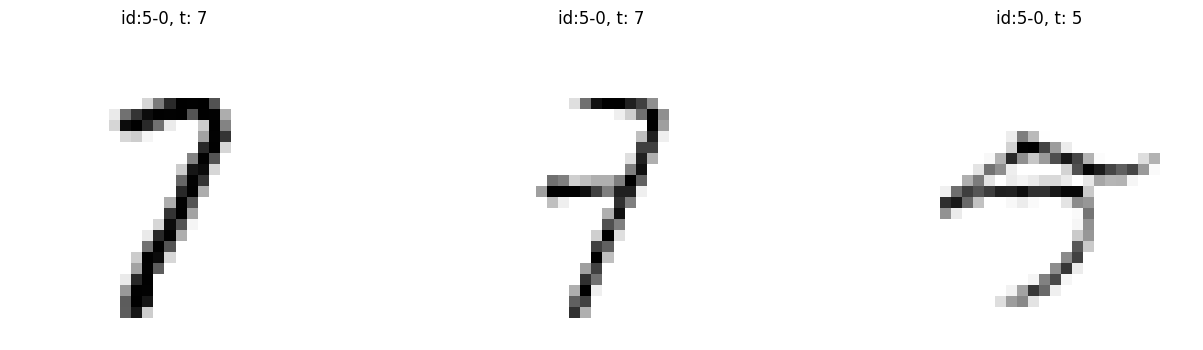

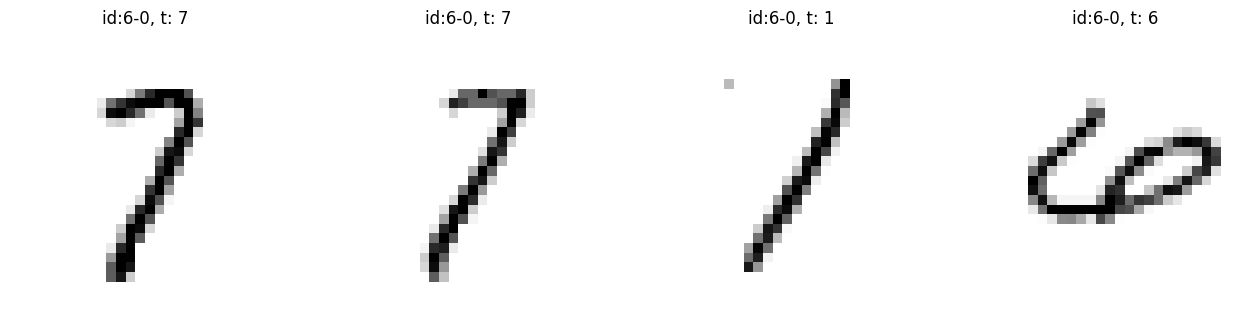

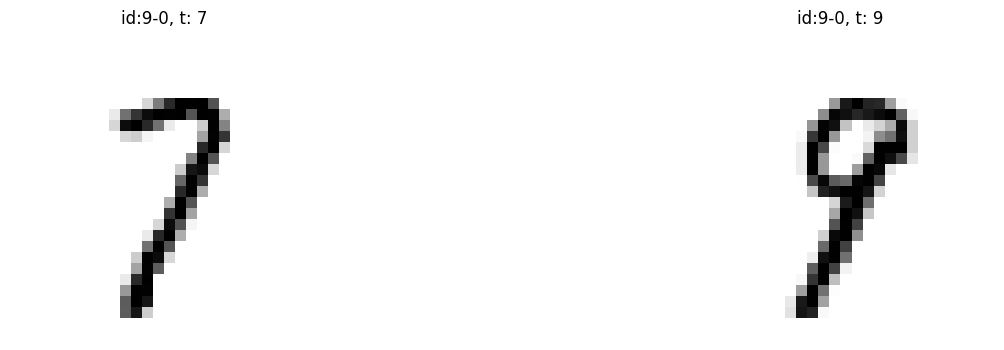

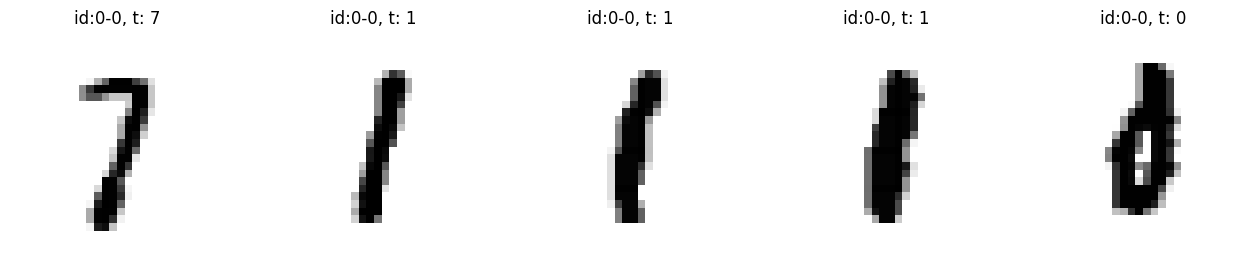

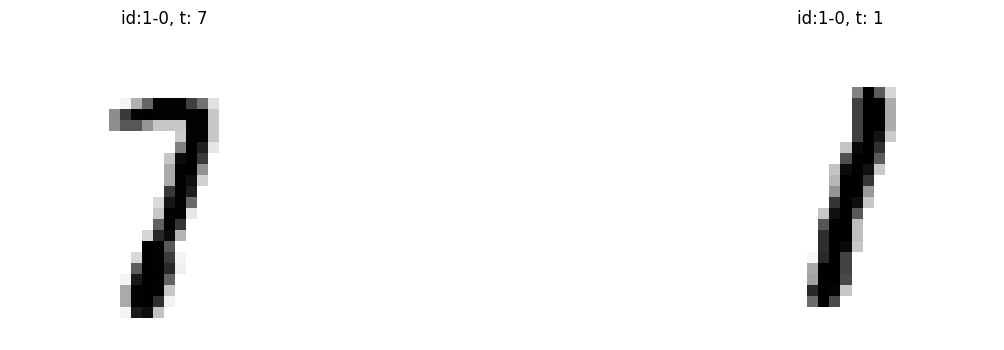

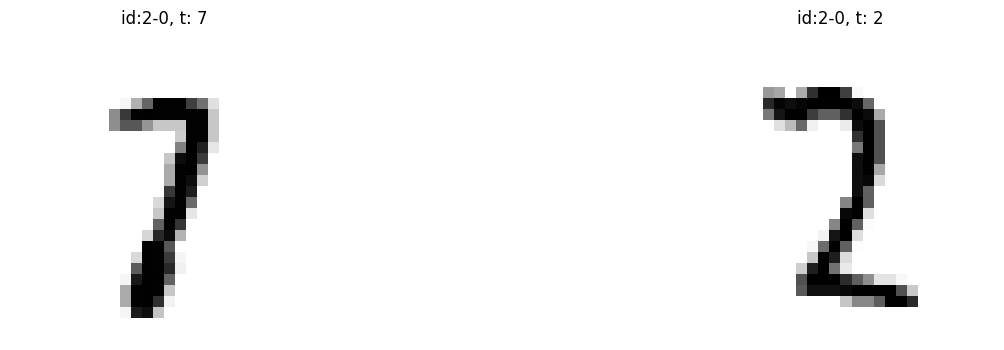

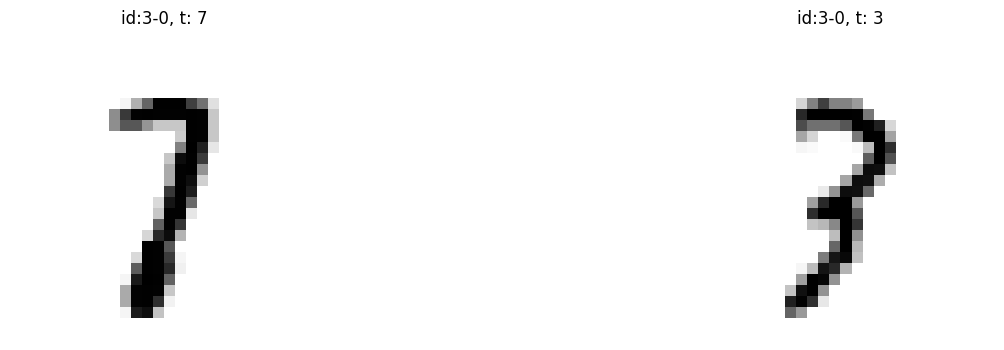

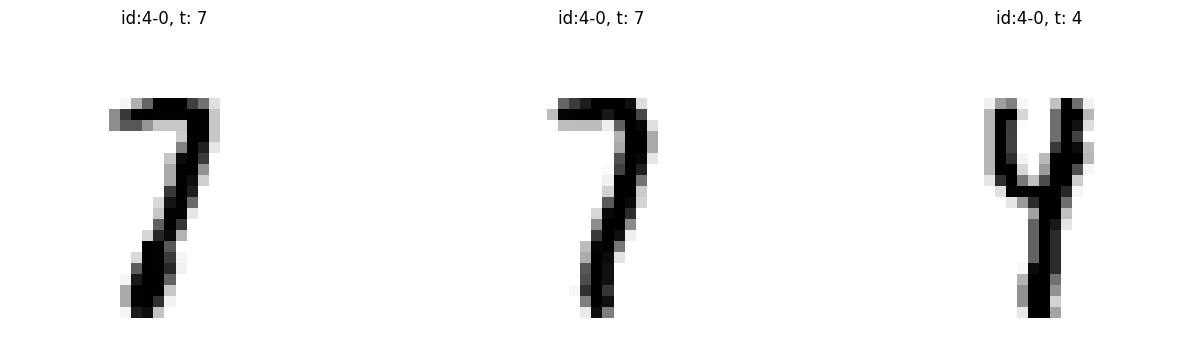

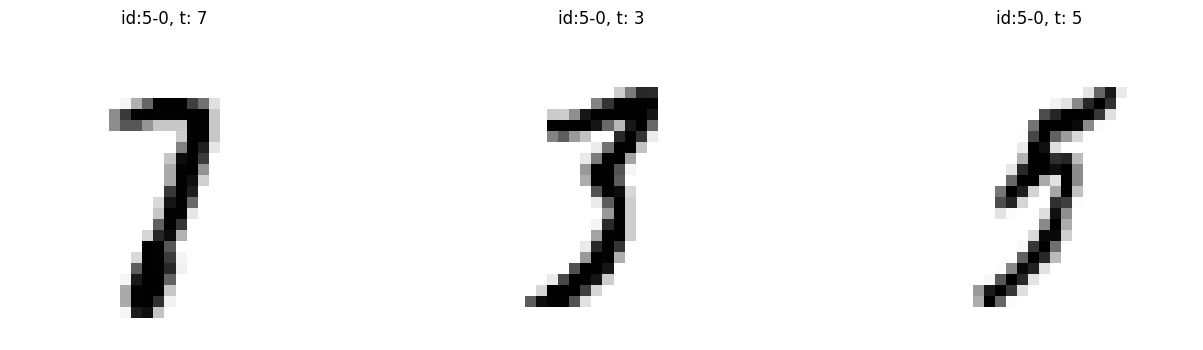

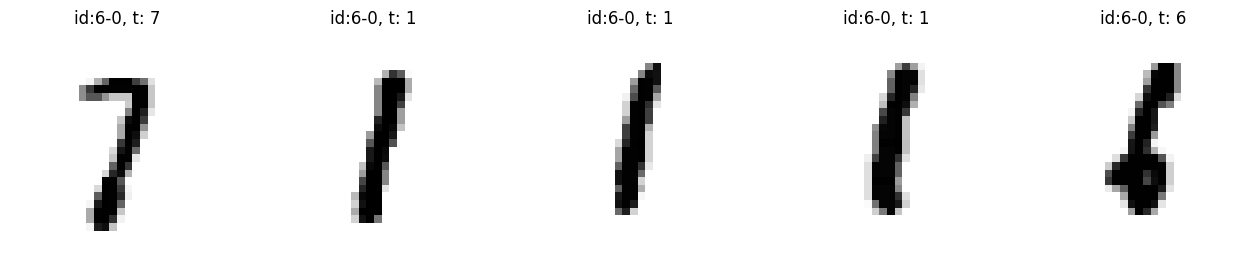

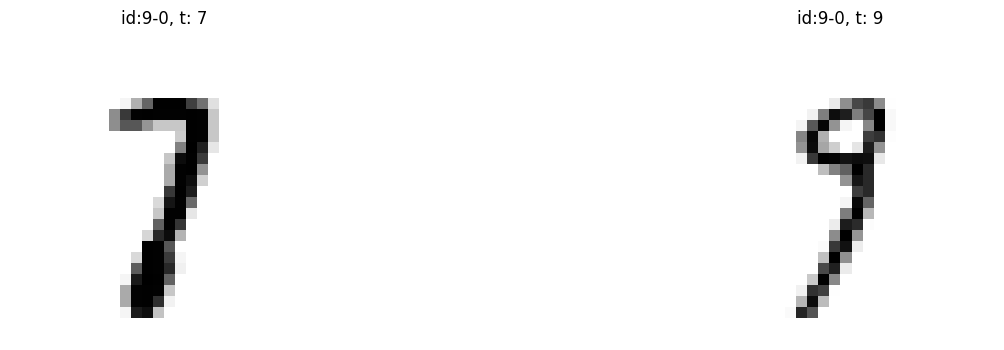

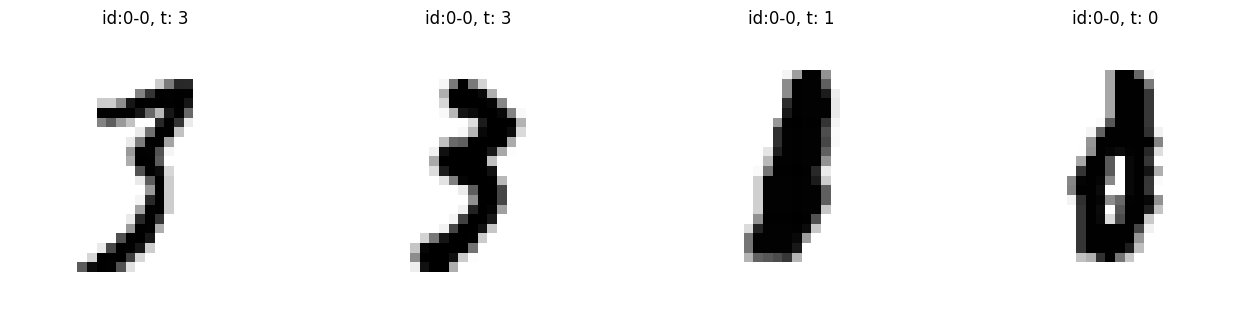

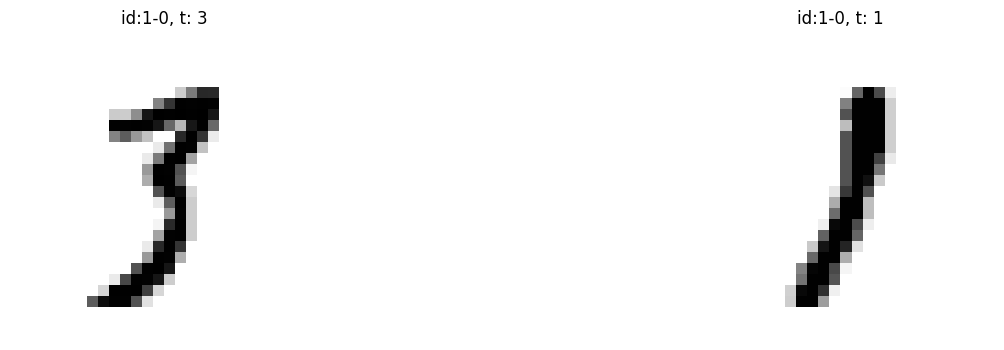

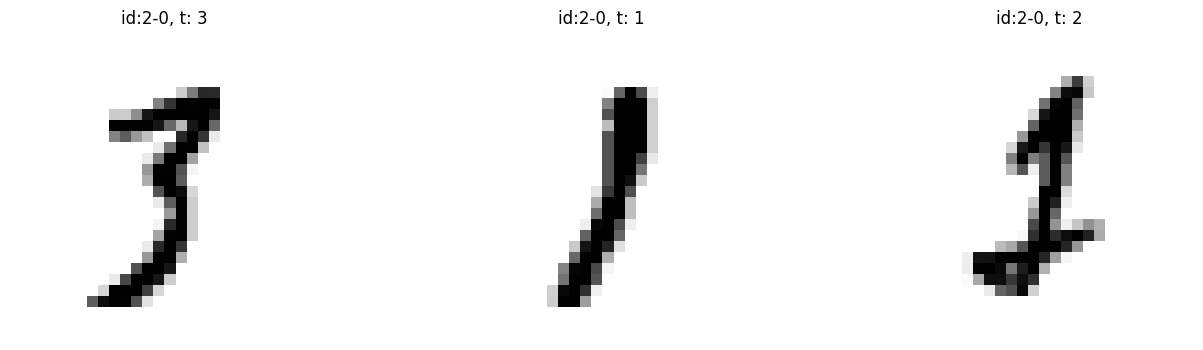

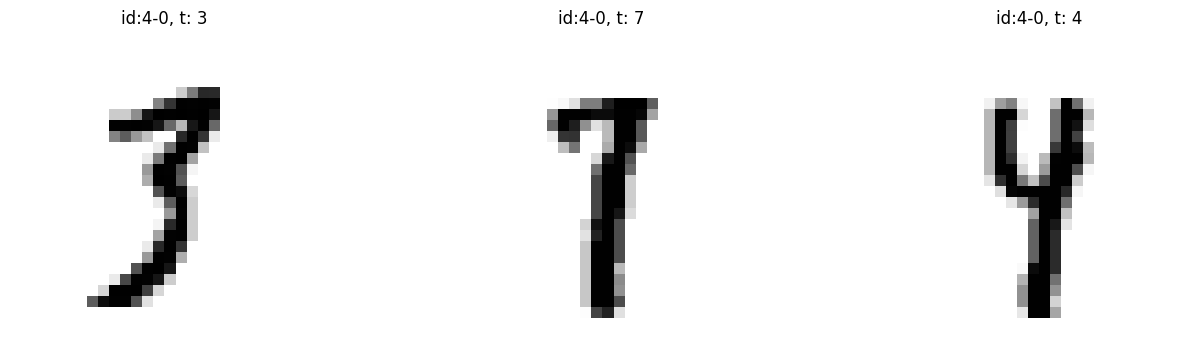

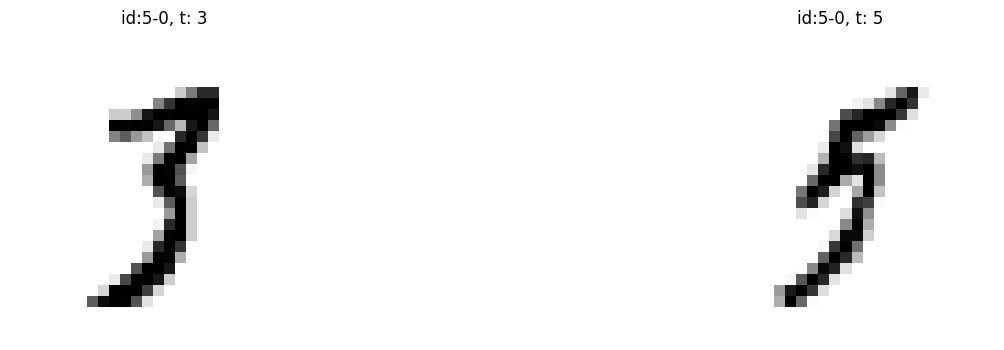

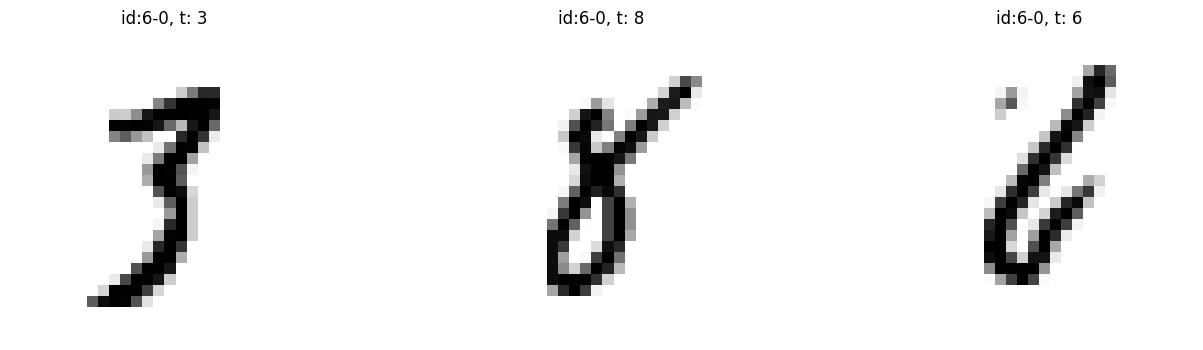

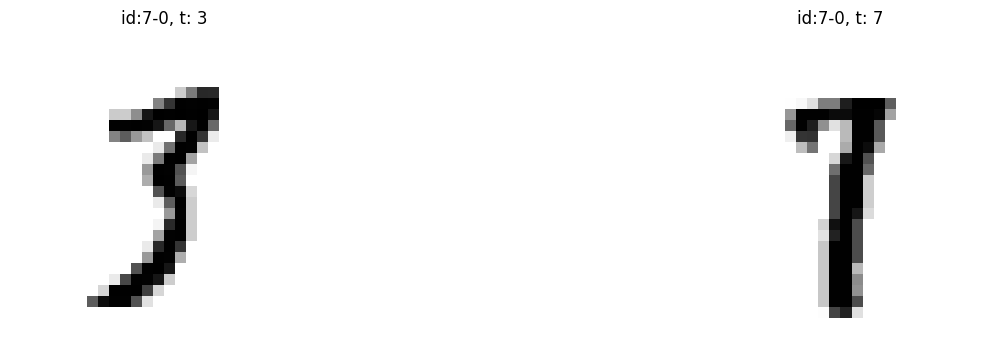

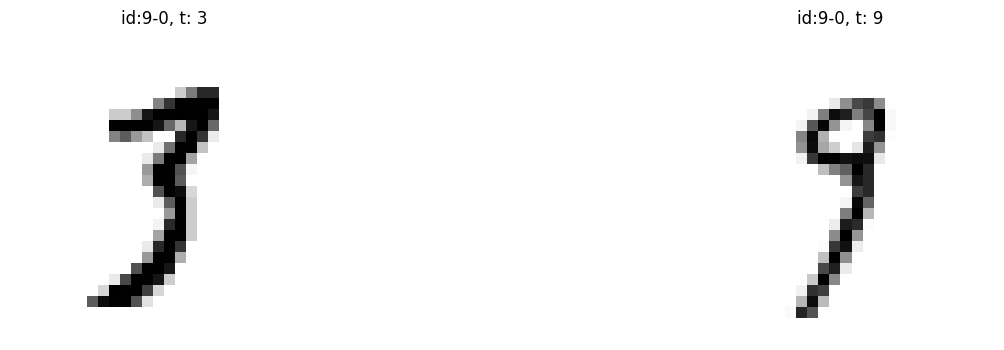

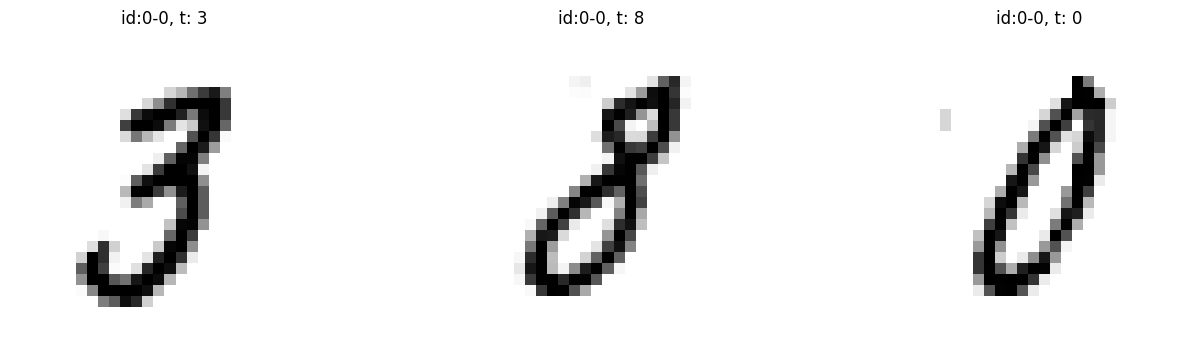

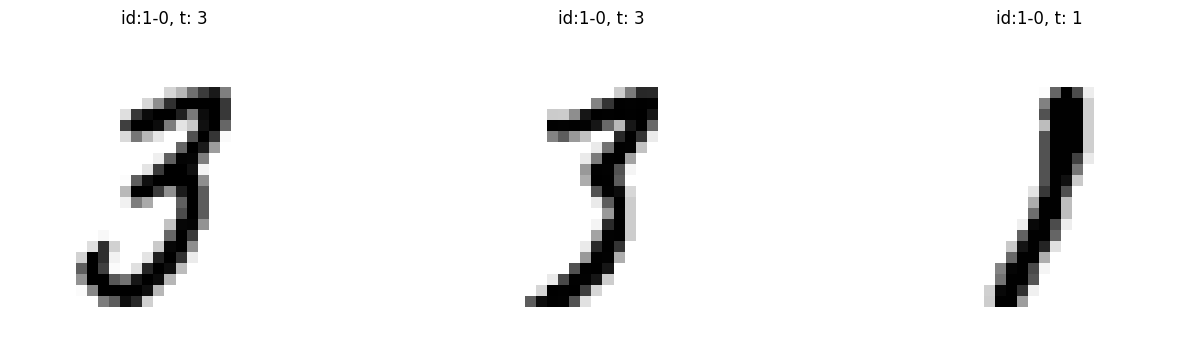

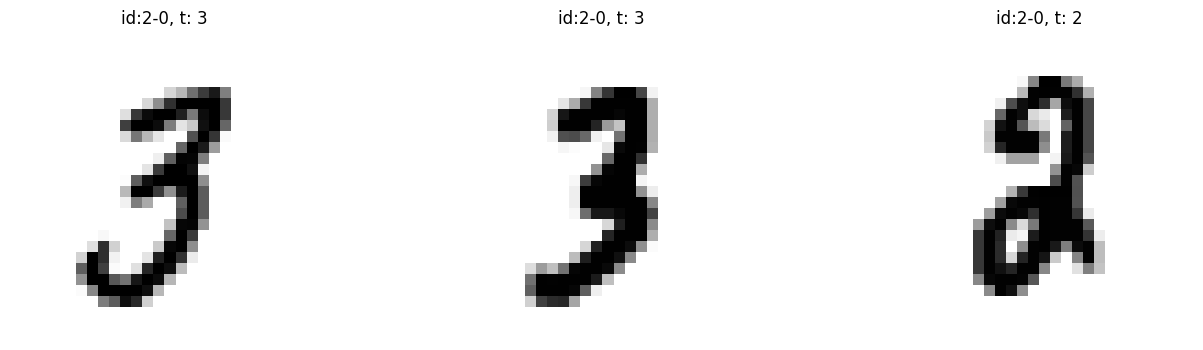

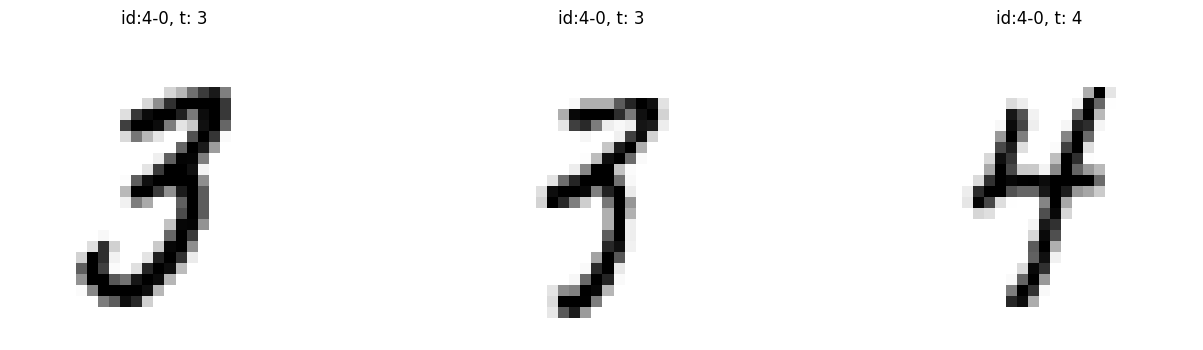

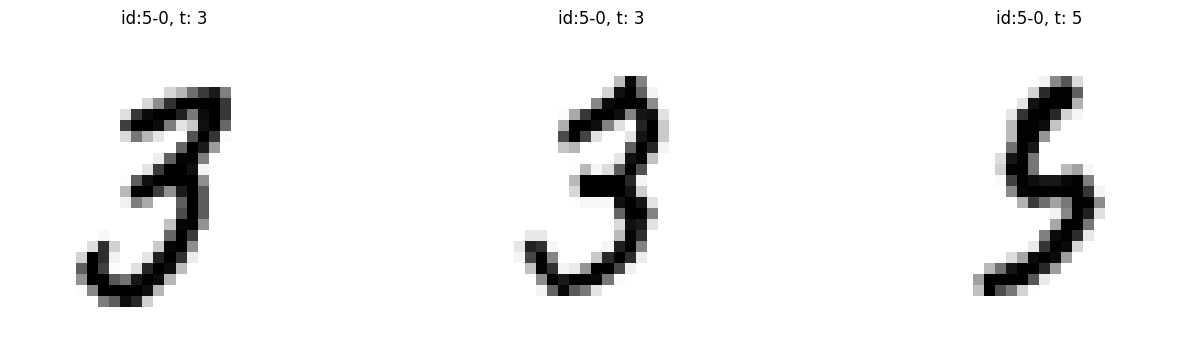

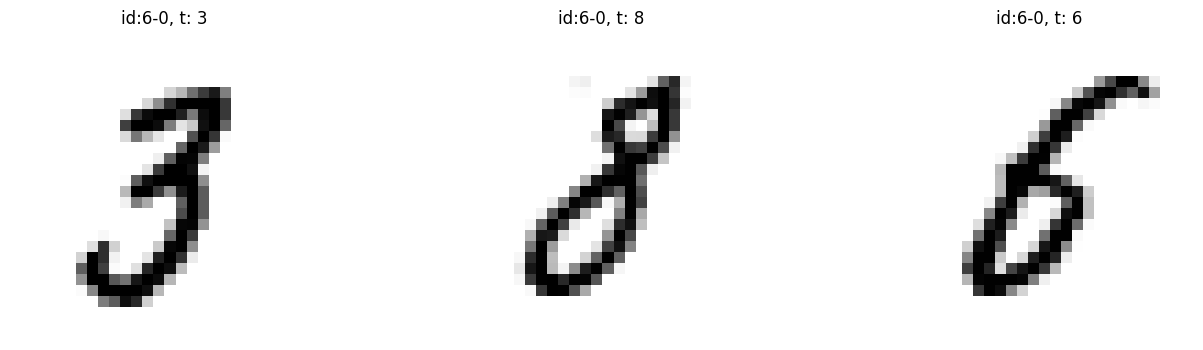

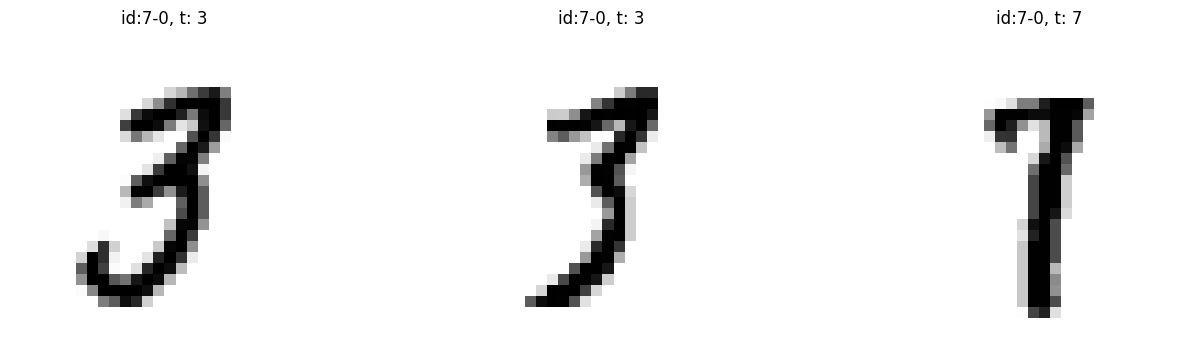

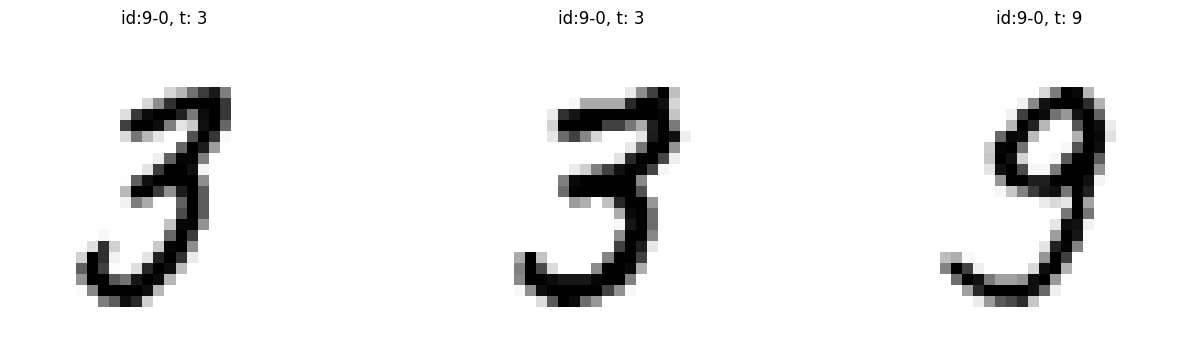

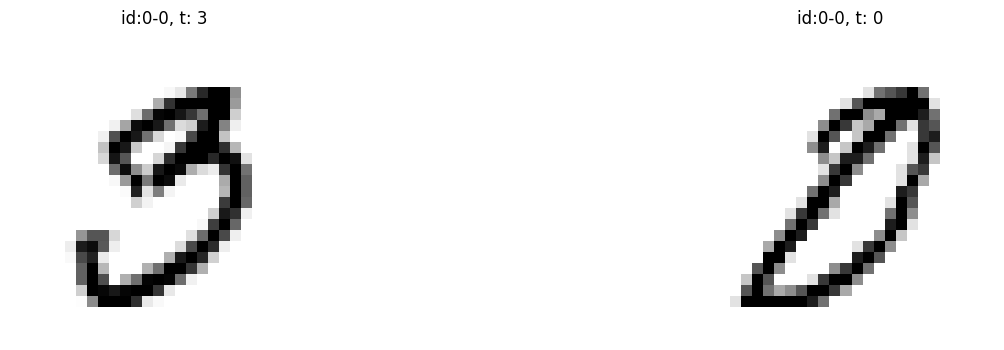

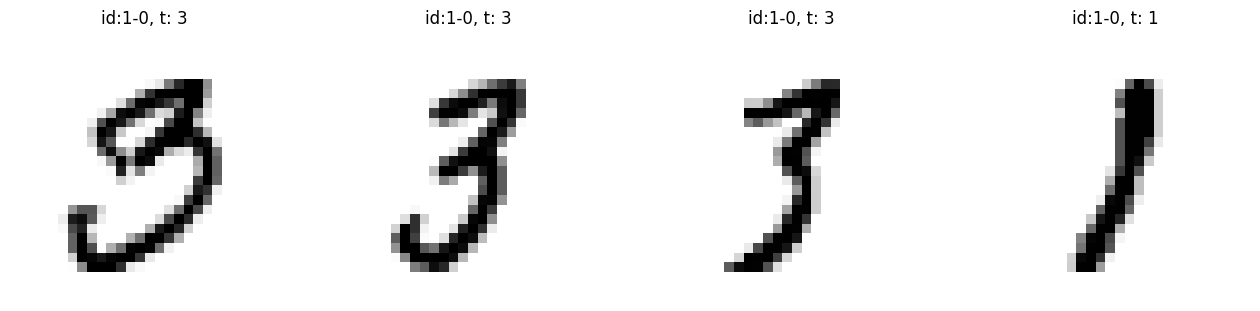

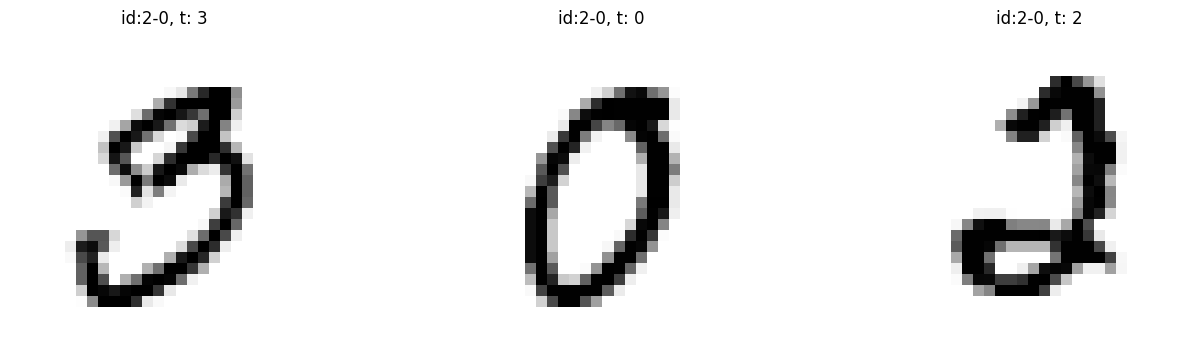

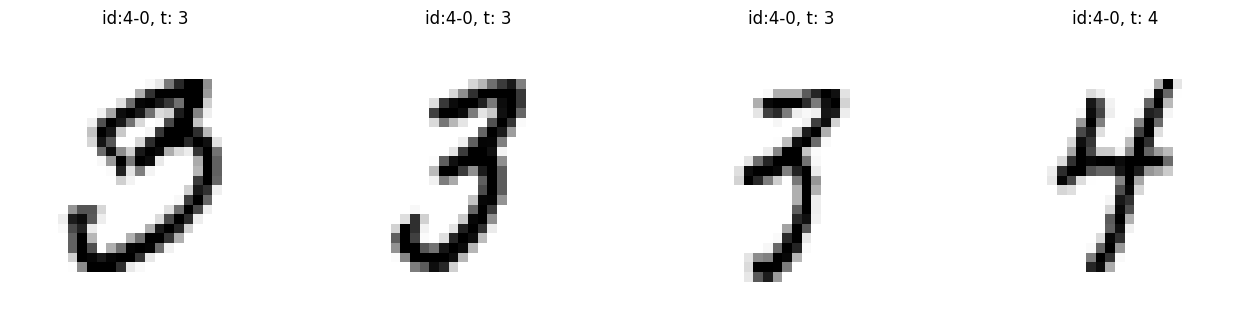

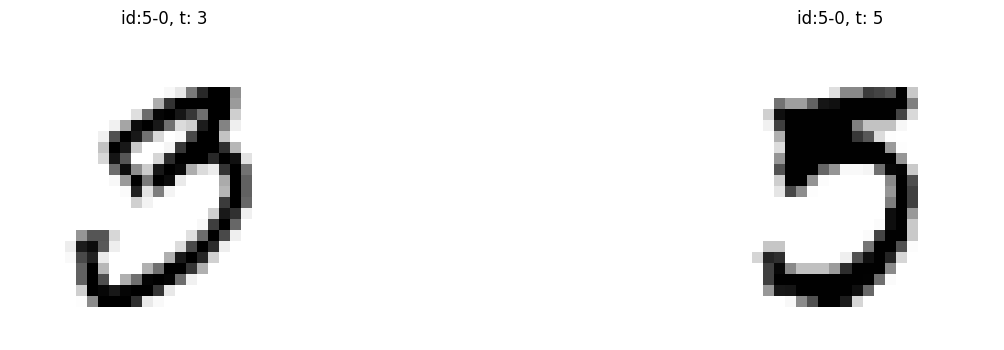

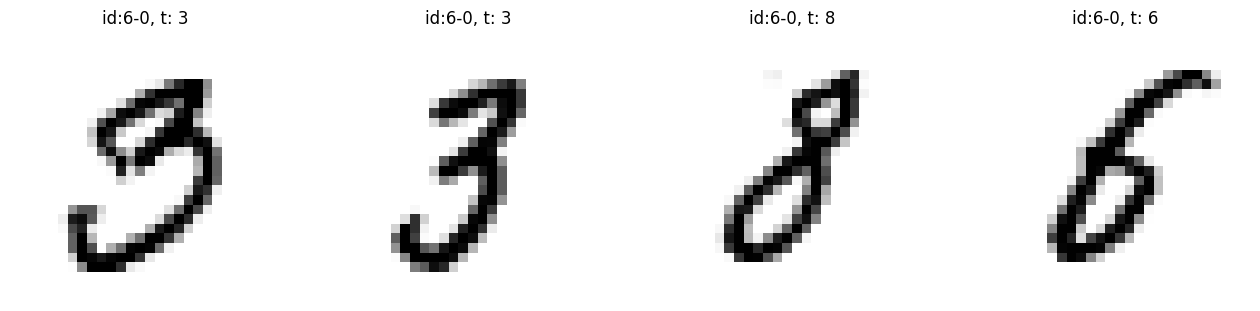

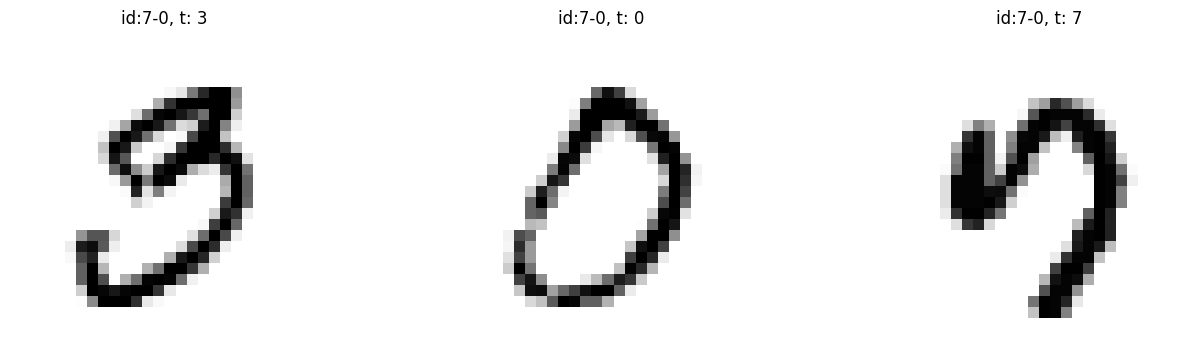

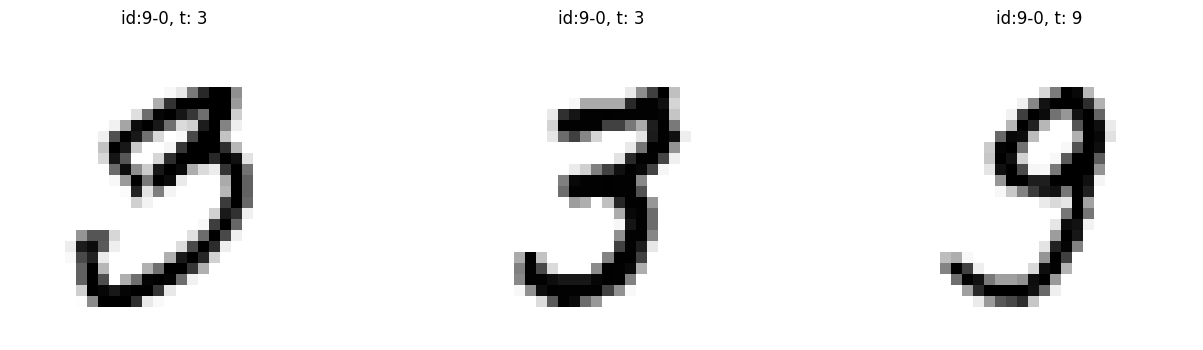

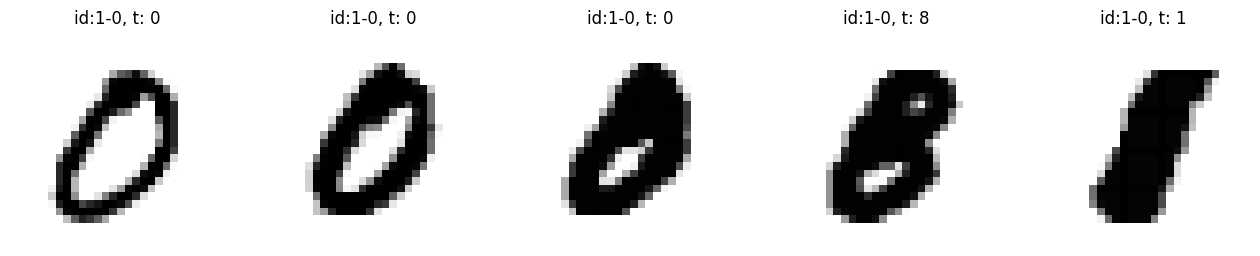

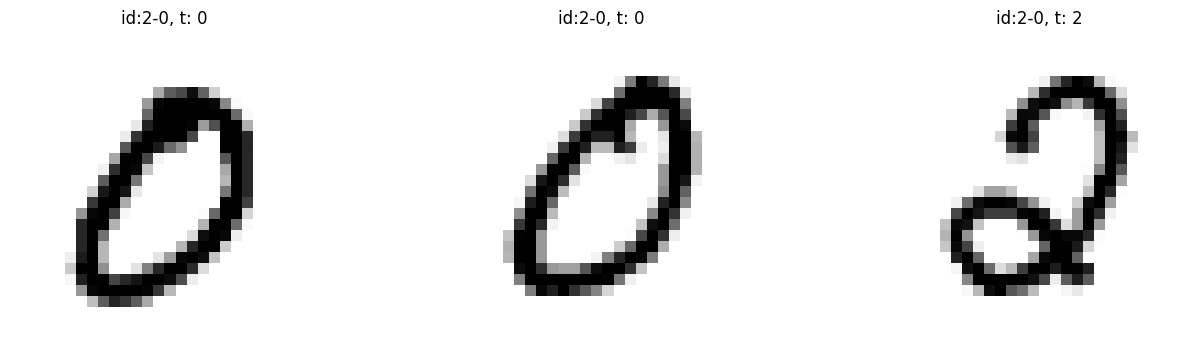

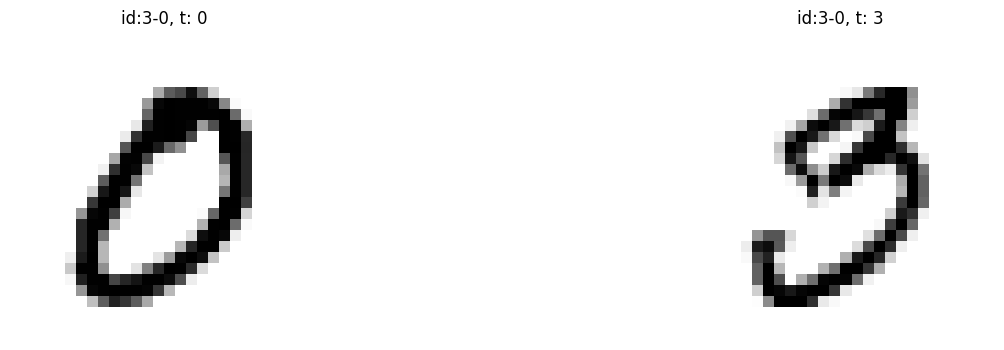

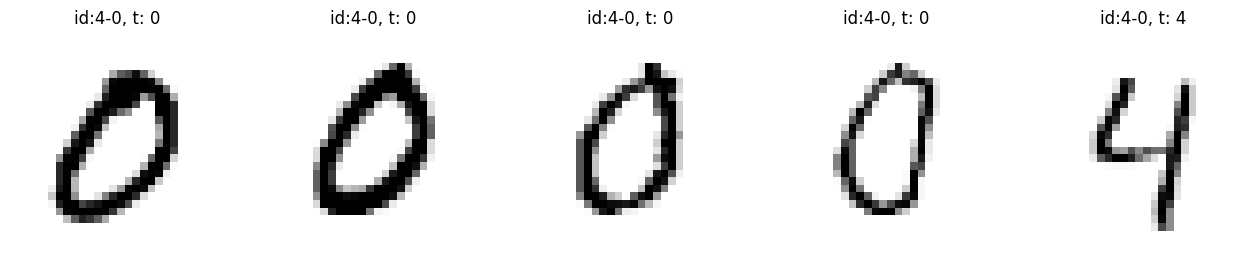

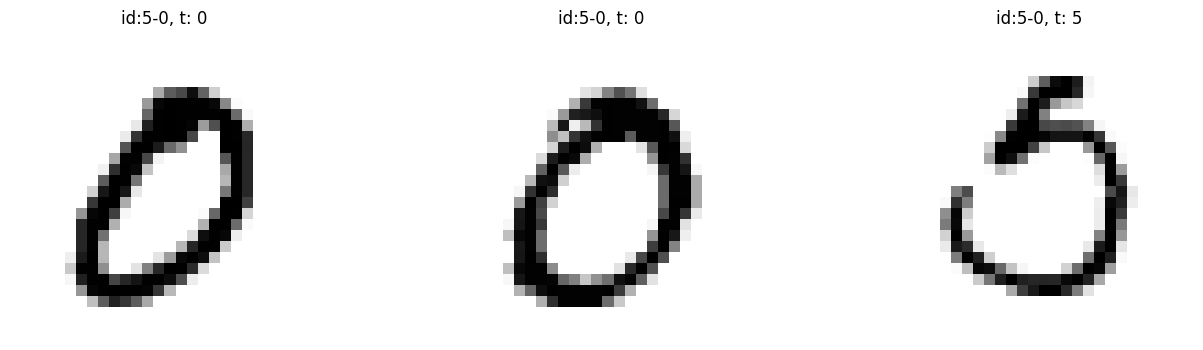

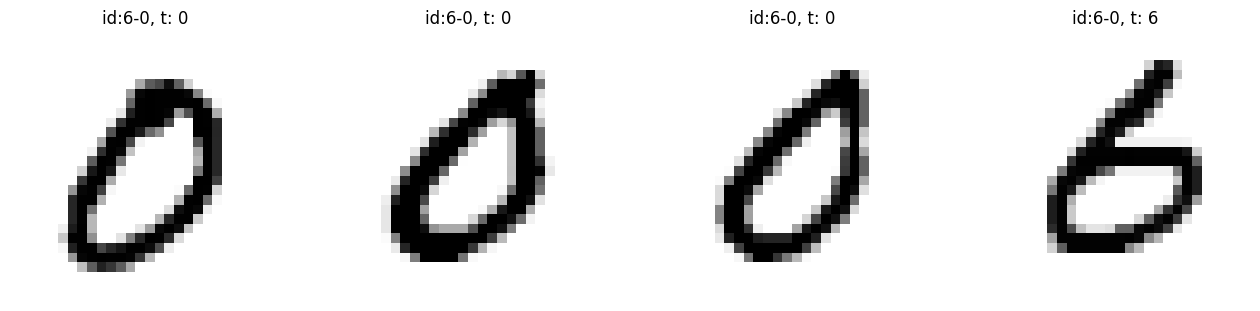

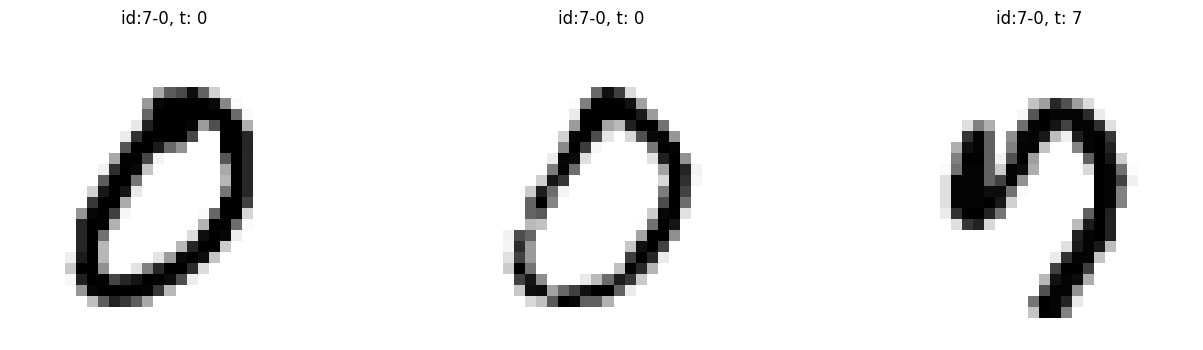

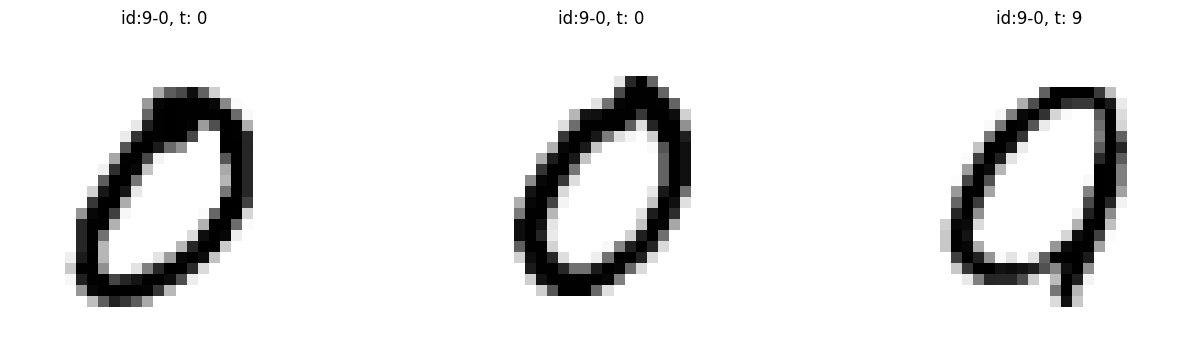

In [19]:
#4
shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=2581)
# print(shortest_path)
for node_idx in shortest_path[:-1]:
    alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
    alt_class_dict, alt_path_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
    print("node index: ", node_idx)
    print(alt_class_dict)
    print(alt_path_dict)
    print_alt_paths(alt_path_dict)

# 2, 16, 5815, 2458, 2581

node index:  728
{0: {np.int64(5196): np.float64(121.67227754761558)}, 1: {np.int64(1031): np.float64(67.76016076200872)}, 2: {np.int64(1614): np.float64(50.8229248532451)}, 3: {np.int64(8012): np.float64(46.559723438708744)}, 4: {np.int64(7350): np.float64(66.63645314635562)}, 5: {np.int64(778): np.float64(99.93082202136591)}, 6: {np.int64(9676): np.float64(134.40133523731566)}, 9: {np.int64(3193): np.float64(35.905077975201735)}}
{0: {np.int64(5196): [728, np.int32(1614), np.int64(5196)]}, 1: {np.int64(1031): [728, np.int32(5650), np.int64(1031)]}, 2: {np.int64(1614): [728, np.int64(1614)]}, 3: {np.int64(8012): [728, np.int64(8012)]}, 4: {np.int64(7350): [728, np.int32(7770), np.int64(7350)]}, 5: {np.int64(778): [728, np.int32(1088), np.int64(778)]}, 6: {np.int64(9676): [728, np.int32(5650), np.int32(1031), np.int64(9676)]}, 9: {np.int64(3193): [728, np.int64(3193)]}}
node index:  2989
{0: {np.int64(7243): np.float64(137.8244422209018)}, 1: {np.int64(6254): np.float64(84.524572922244

/tmp/ipykernel_8246/1967381332.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4*nrows))


node index:  9339
{0: {np.int64(7243): np.float64(146.23096009251935)}, 1: {np.int64(8772): np.float64(123.34306228784152)}, 2: {np.int64(854): np.float64(95.5869830339221)}, 3: {np.int64(8709): np.float64(58.375445247925605)}, 4: {np.int64(8850): np.float64(49.055541953344544)}, 5: {np.int64(4290): np.float64(62.261302759634)}, 6: {np.int64(8888): np.float64(147.31599720099462)}, 7: {np.int64(8699): np.float64(46.640437719965114)}}
{0: {np.int64(7243): [np.int32(9339), np.int32(409), np.int32(8979), np.int64(7243)]}, 1: {np.int64(8772): [np.int32(9339), np.int32(707), np.int32(6599), np.int64(8772)]}, 2: {np.int64(854): [np.int32(9339), np.int32(383), np.int64(854)]}, 3: {np.int64(8709): [np.int32(9339), np.int64(8709)]}, 4: {np.int64(8850): [np.int32(9339), np.int64(8850)]}, 5: {np.int64(4290): [np.int32(9339), np.int64(4290)]}, 6: {np.int64(8888): [np.int32(9339), np.int32(389), np.int32(8868), np.int64(8888)]}, 7: {np.int64(8699): [np.int32(9339), np.int64(8699)]}}
node index:  406

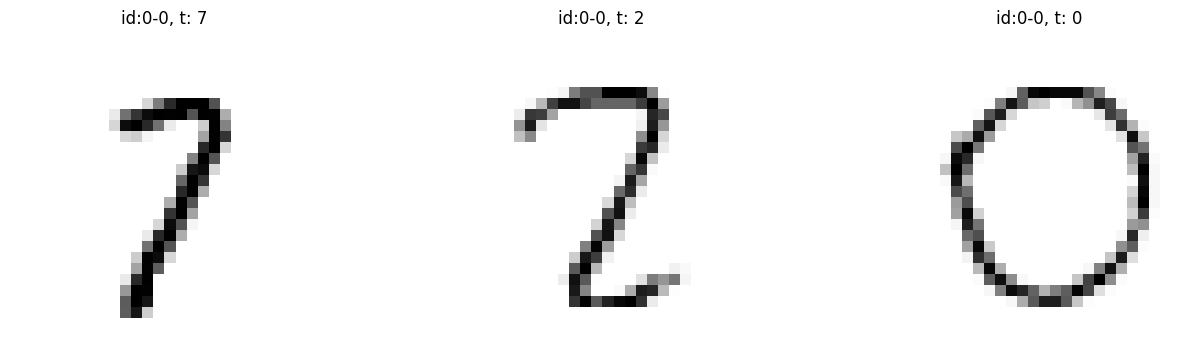

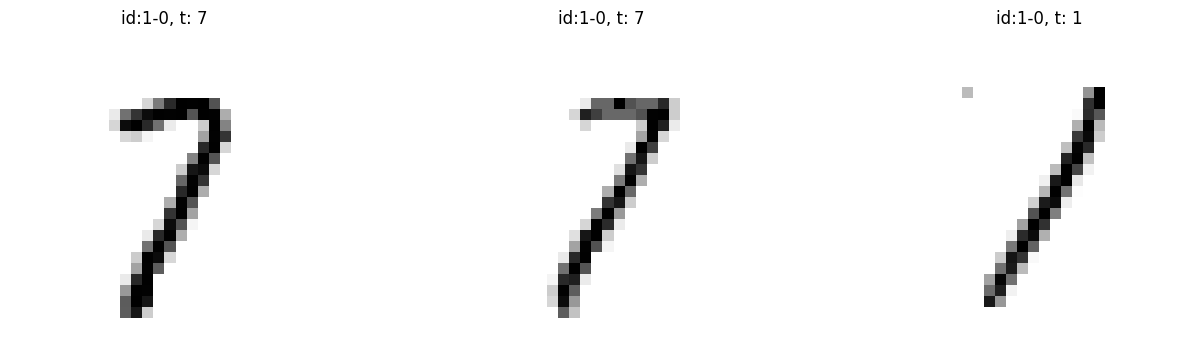

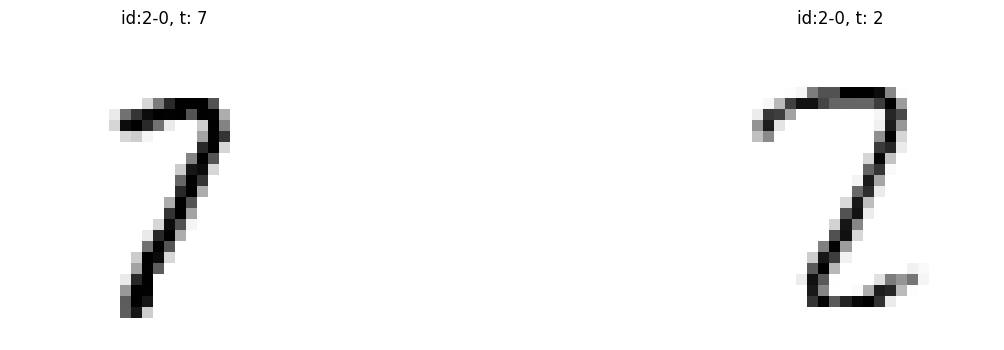

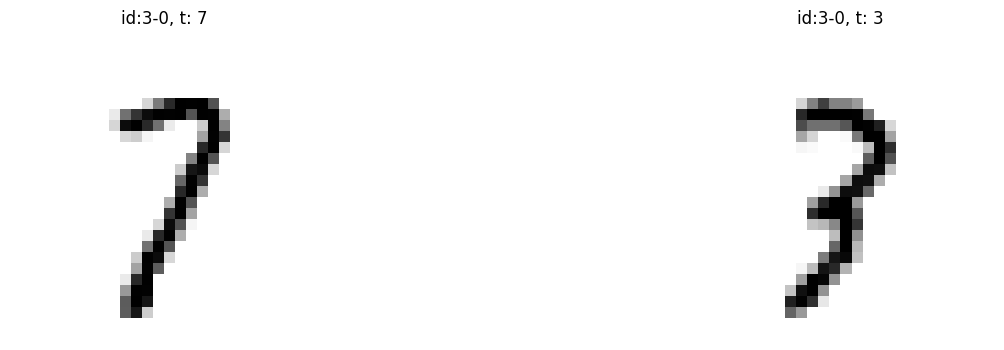

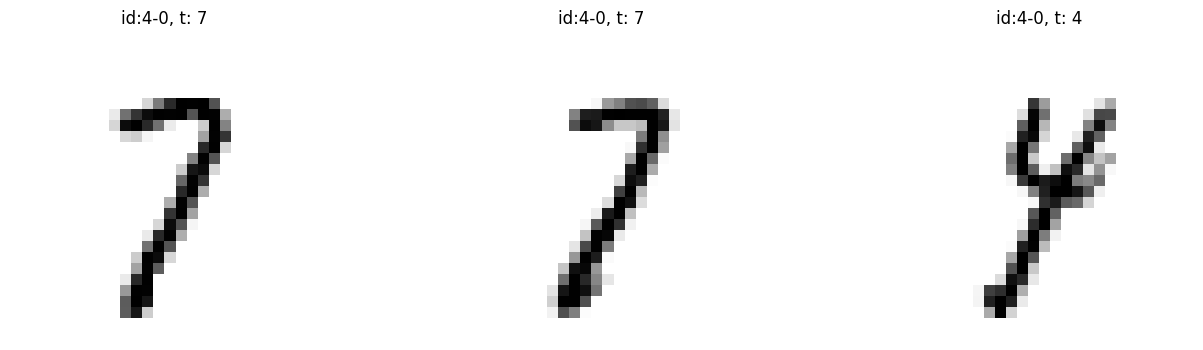

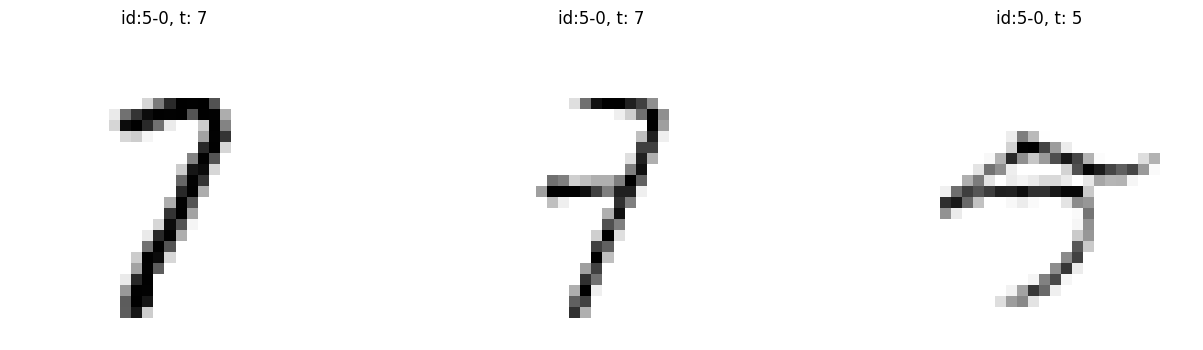

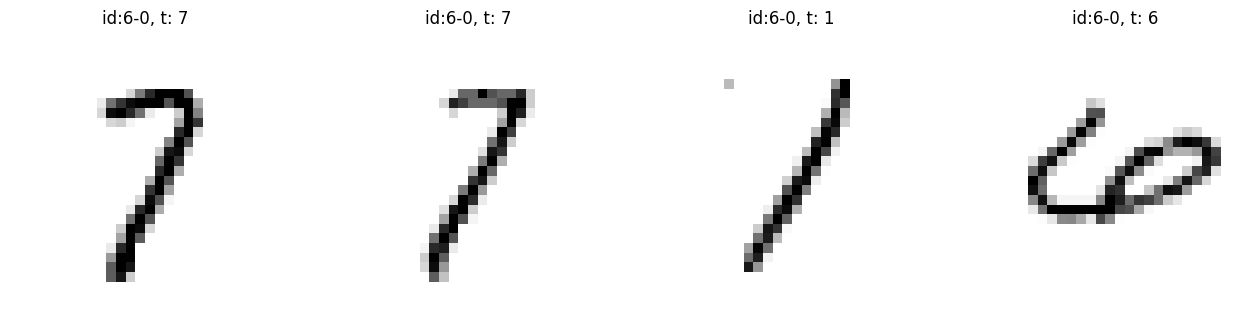

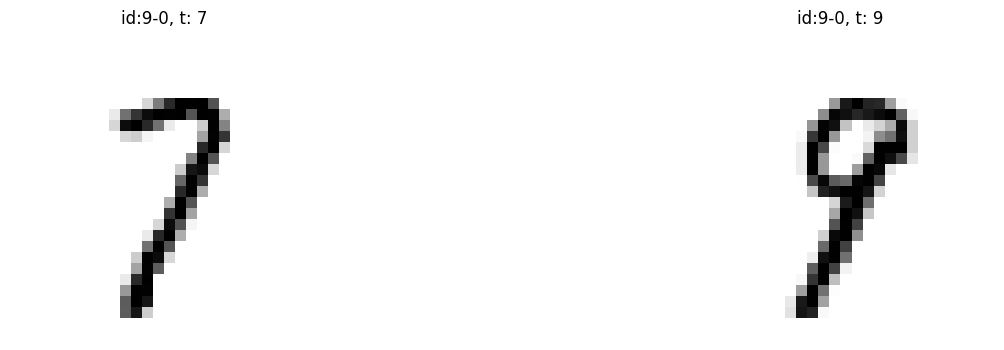

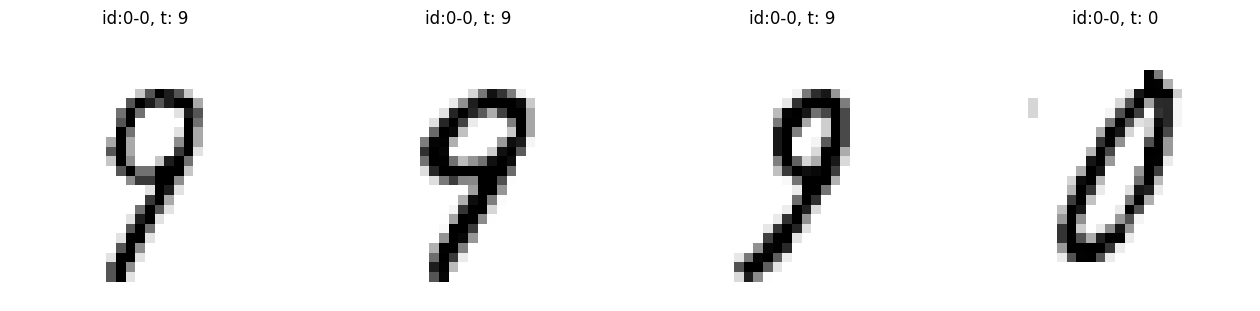

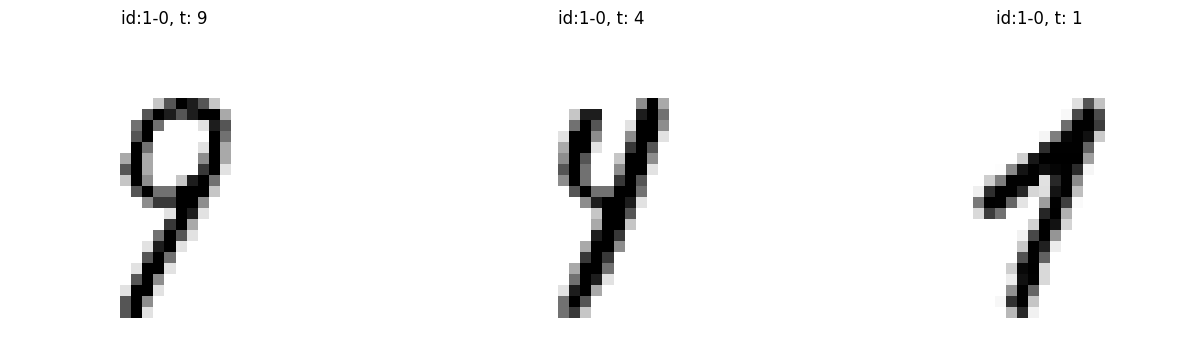

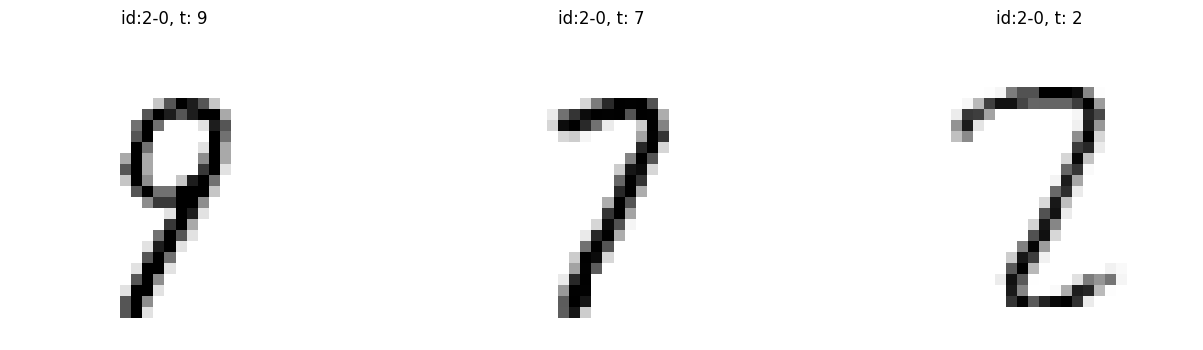

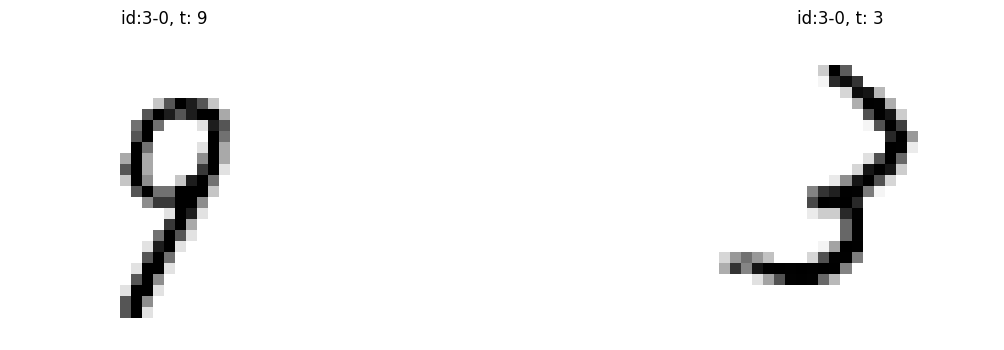

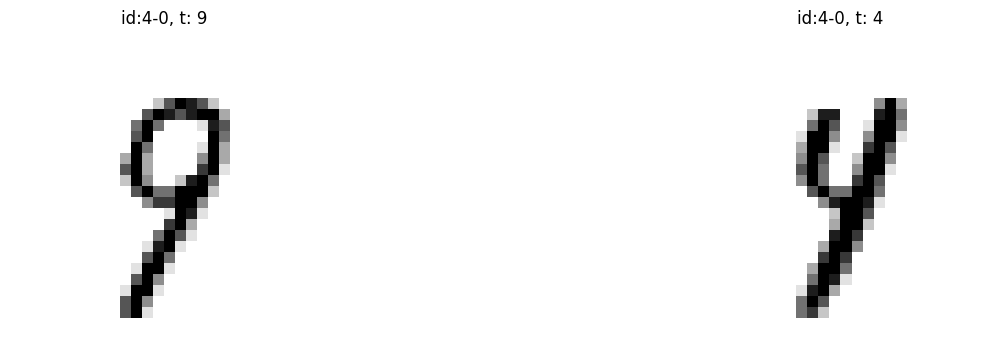

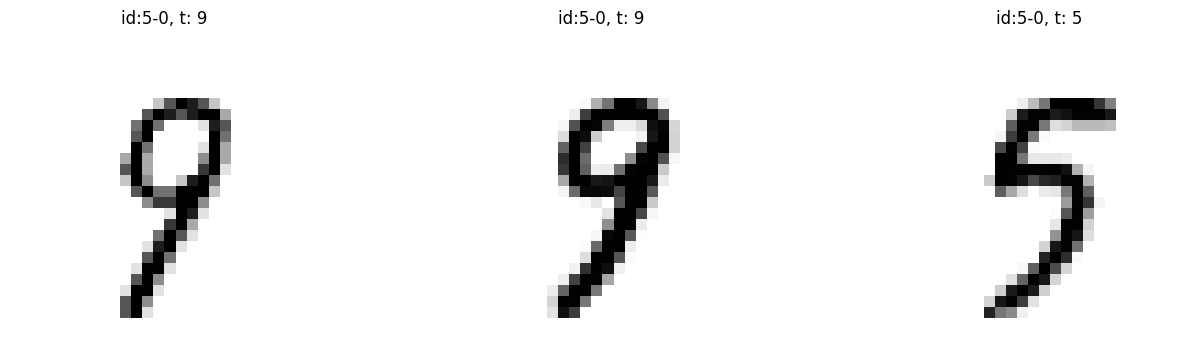

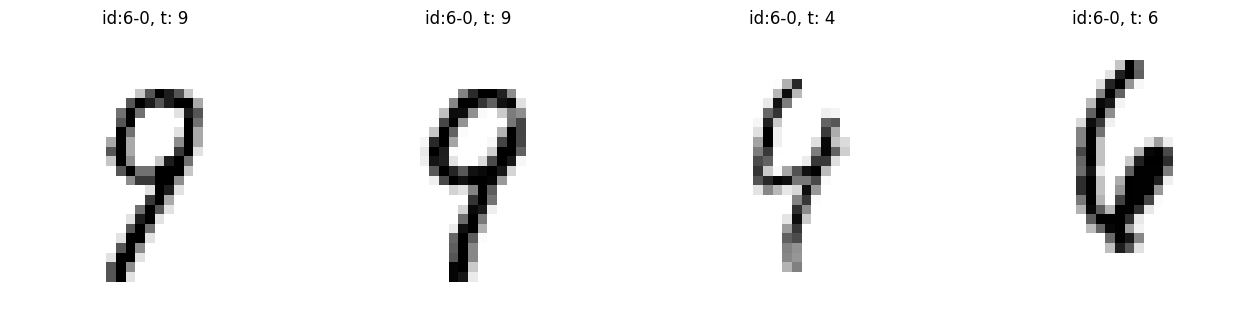

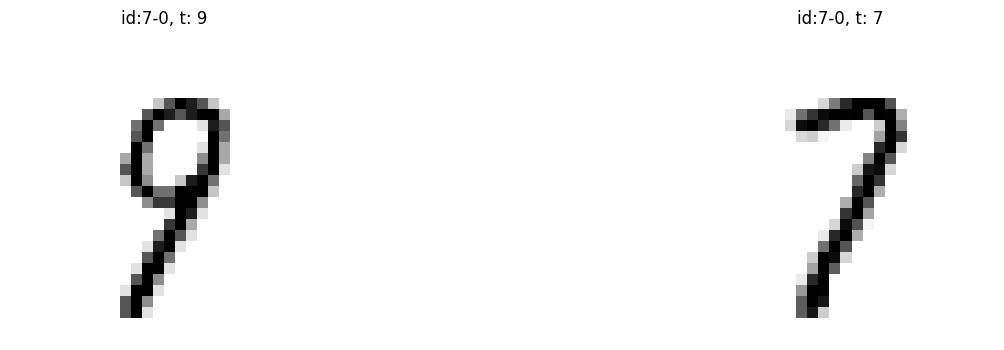

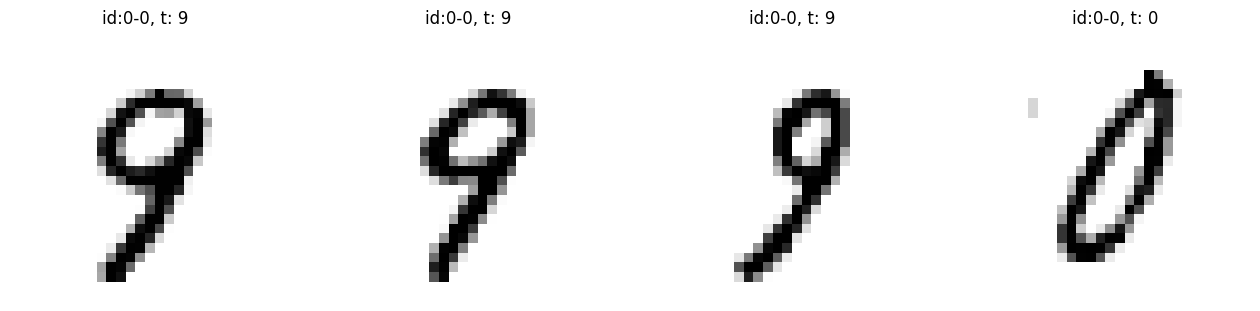

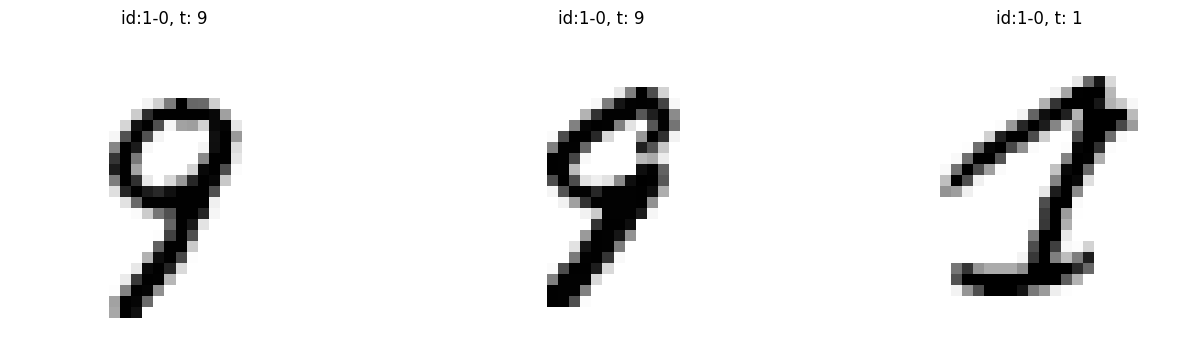

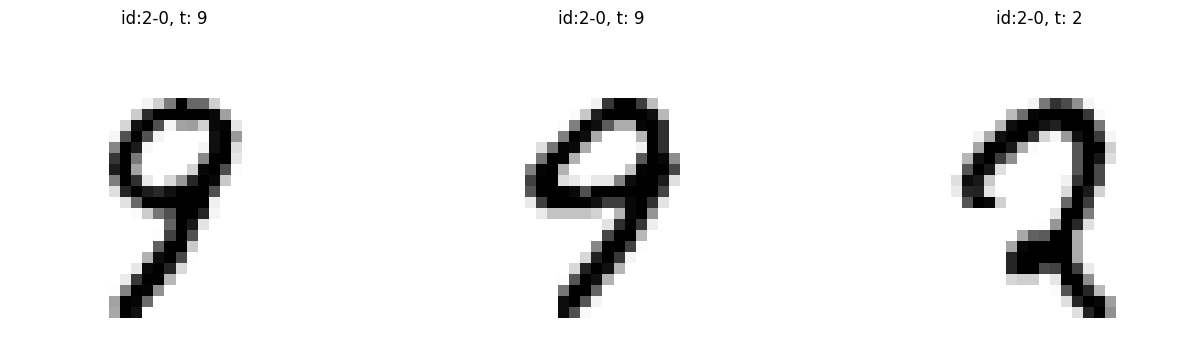

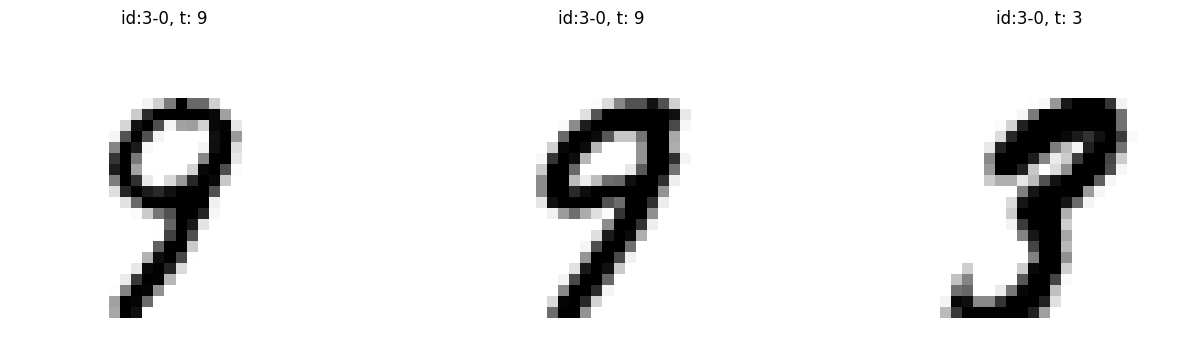

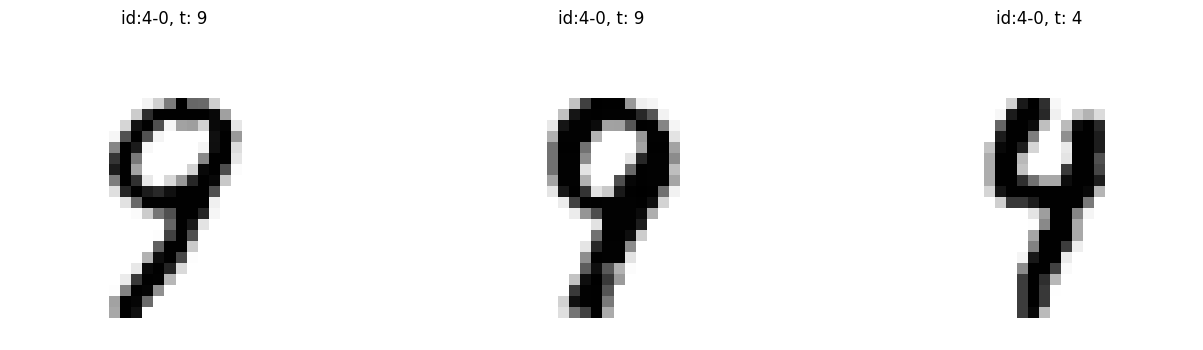

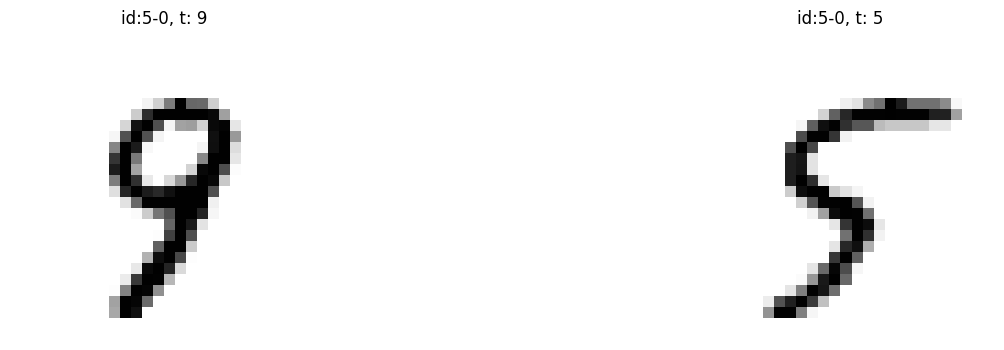

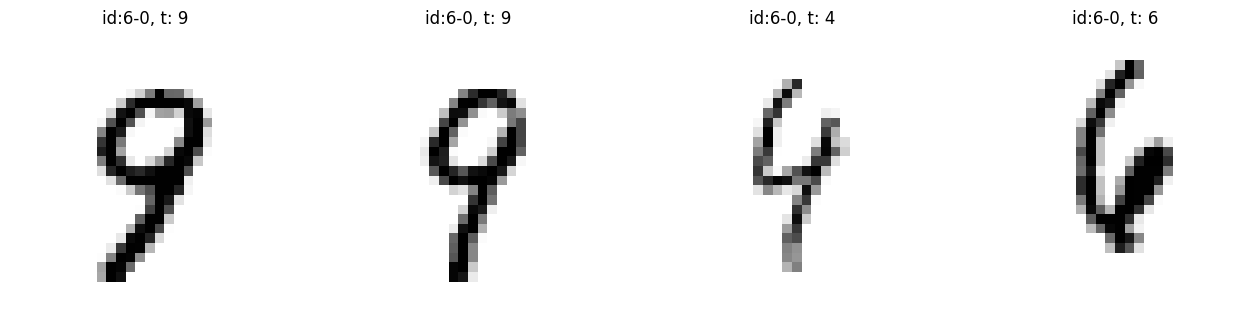

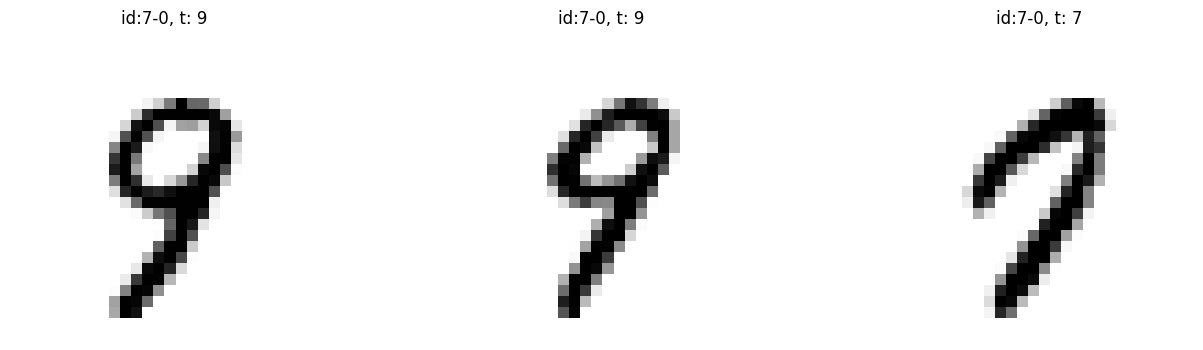

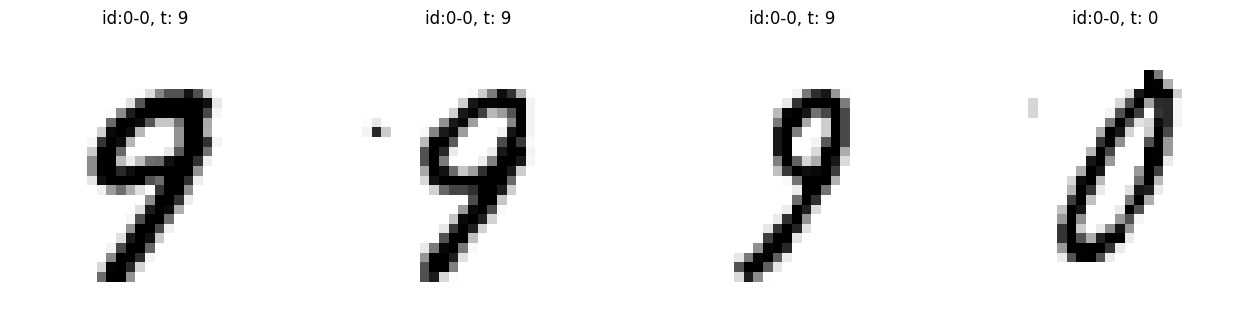

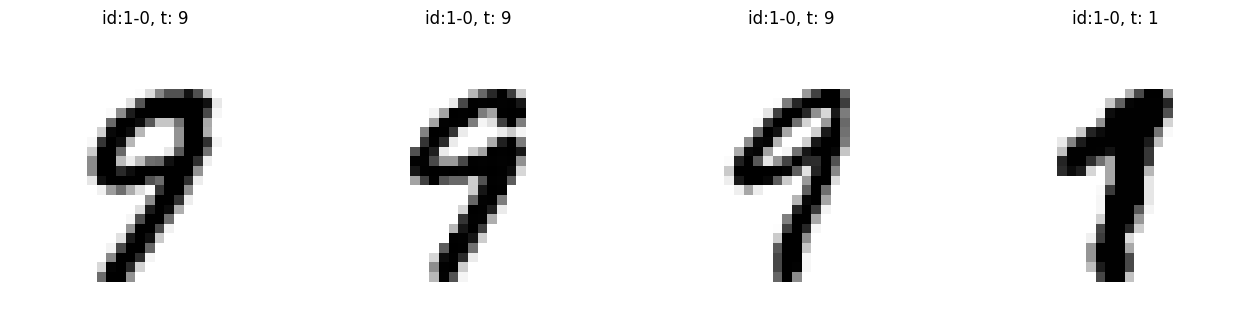

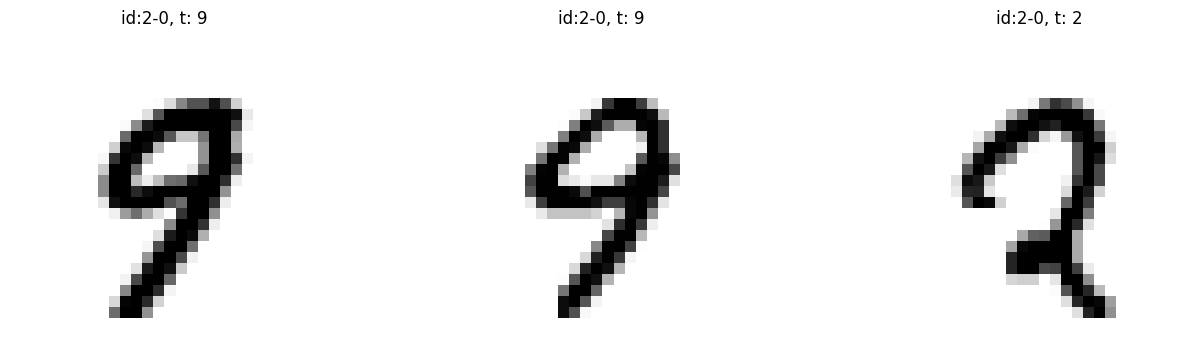

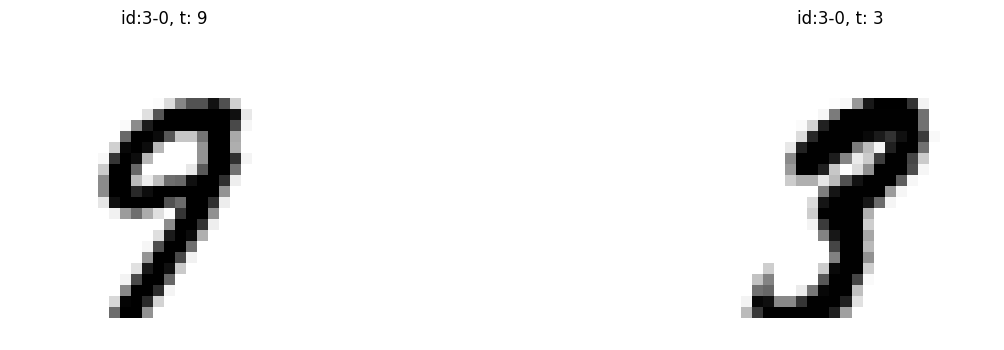

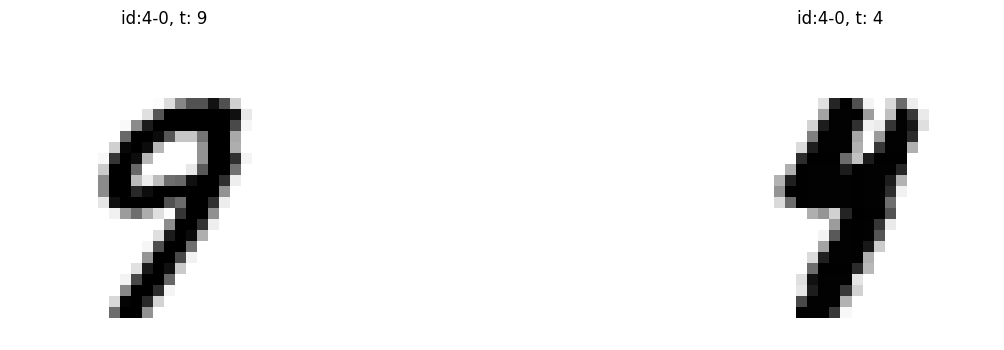

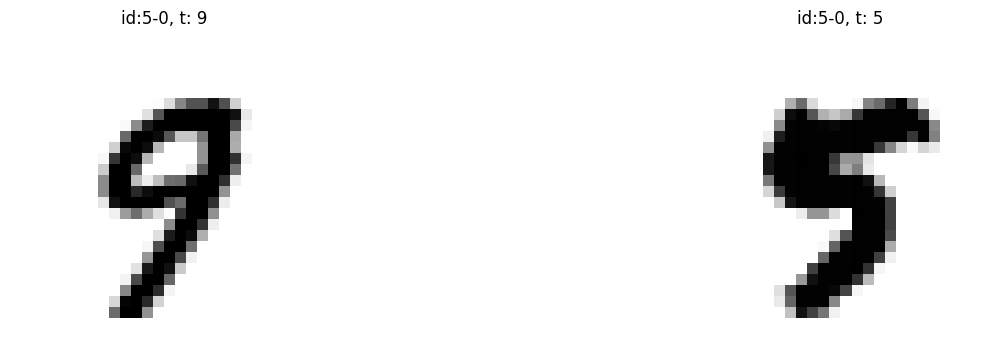

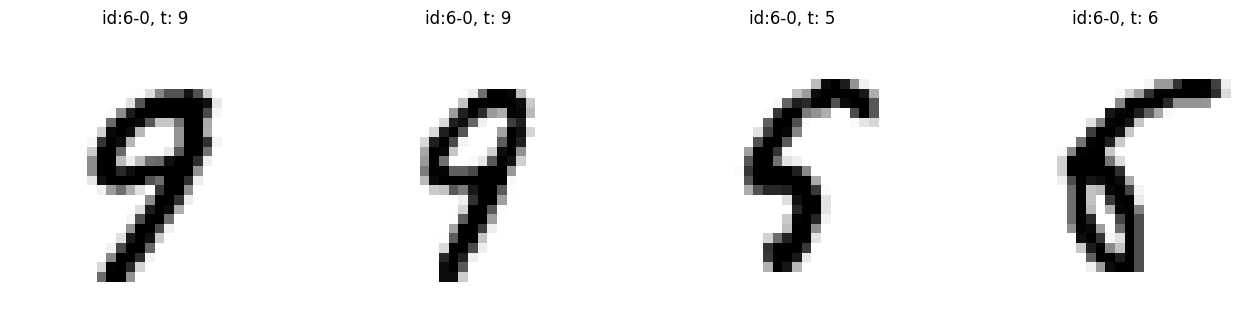

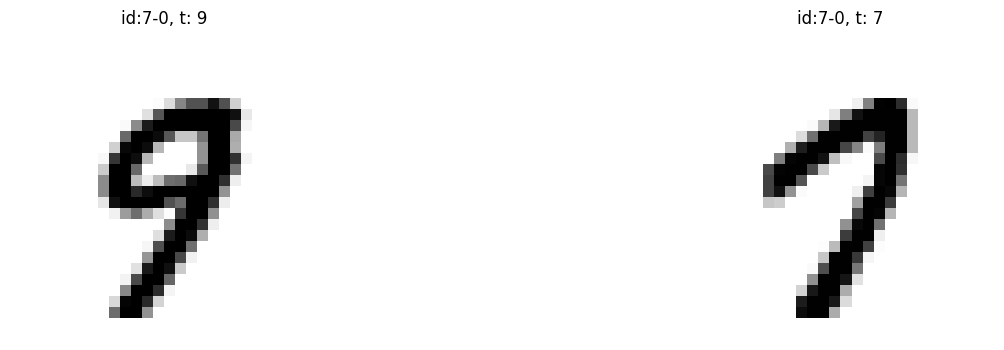

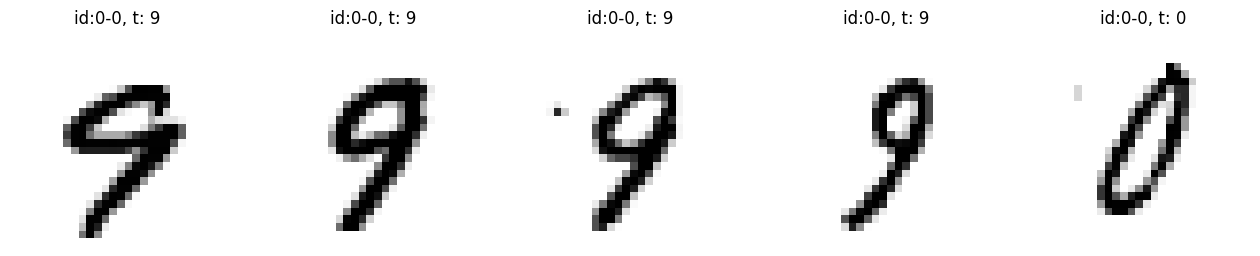

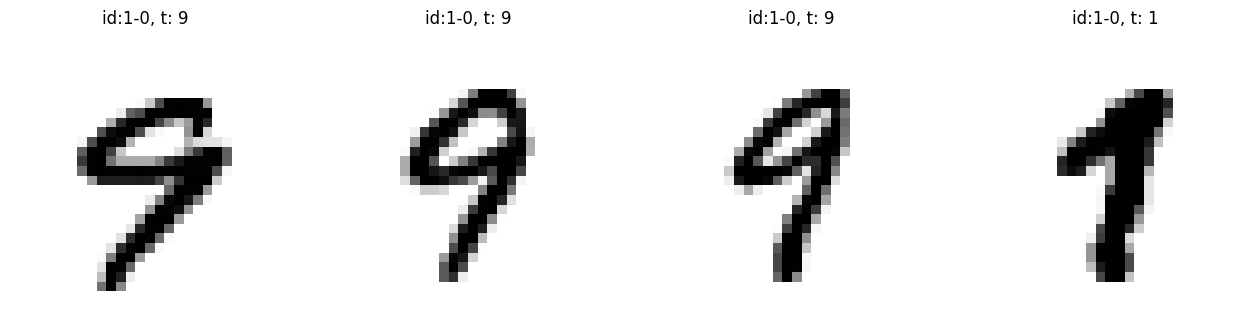

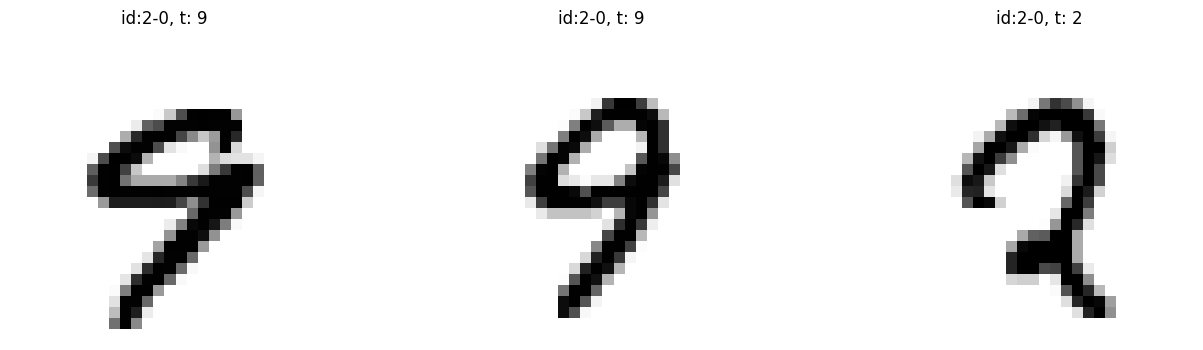

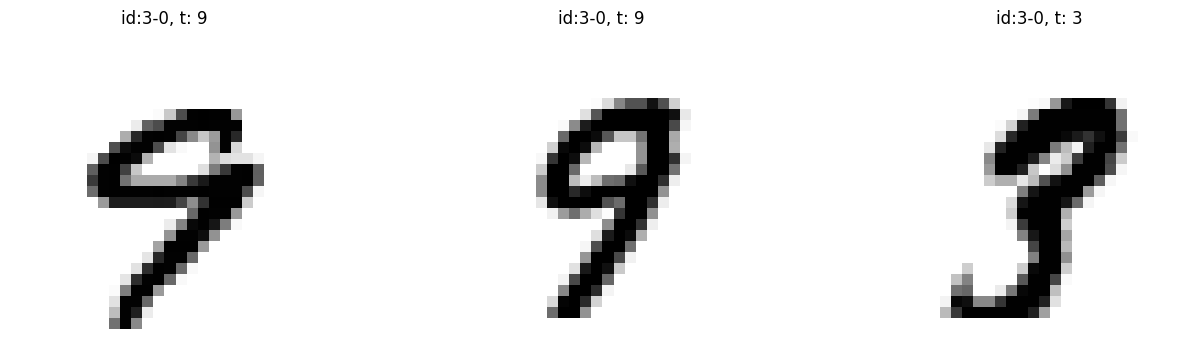

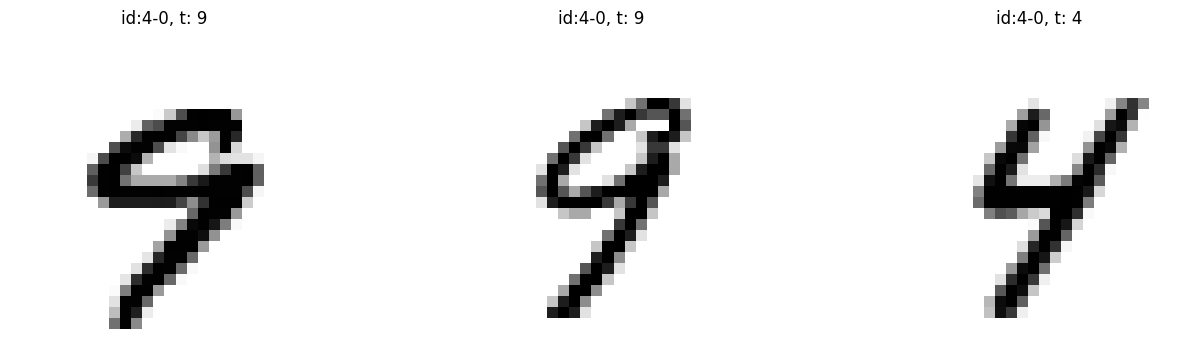

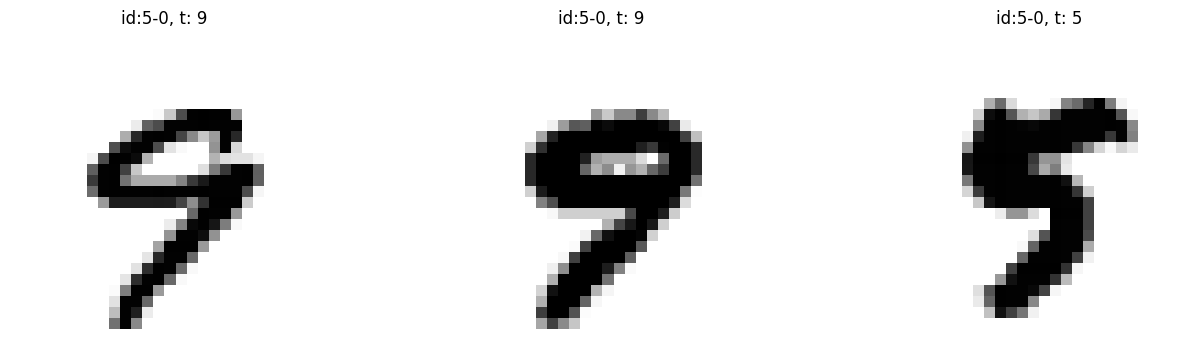

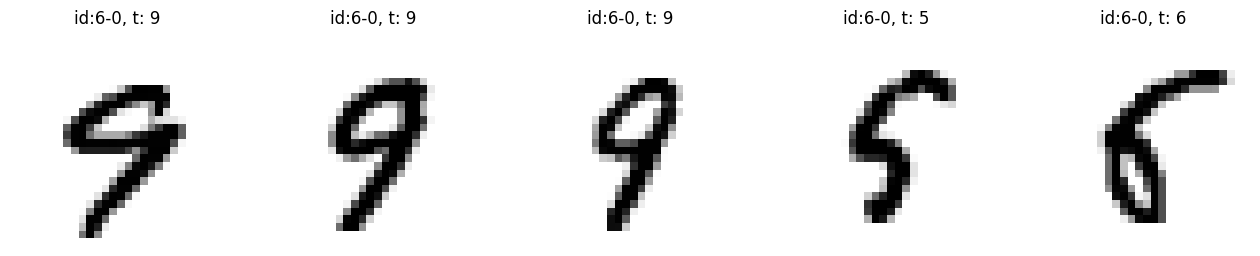

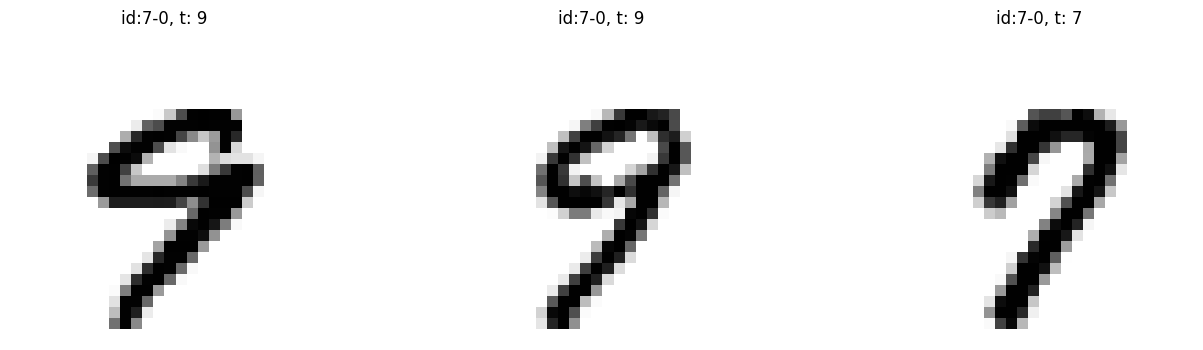

In [20]:
#7
shortest_path = reconstruct_shortest_path(predecessors, start_point_idx=start_point_idx, end_point_idx=626)
# print()
for node_idx in shortest_path[:-1]:
    alt_classes = list(set(class_labels) - set([target_class, y[node_idx]]))
    alt_class_dict, alt_path_dict = get_user_agency(sp_graph, node_idx, alt_classes, predictions, y, class_labels)
    print("node index: ", node_idx)
    print(alt_class_dict)
    print(alt_path_dict)
    print_alt_paths(alt_path_dict)

# 2, 5292, 1462, 5100, 3977, 626

In [21]:
((144.2724164738749 + 67.54503585100791 + 48.741752057600024 + 49.25593903366071 + 70.3800658408136)/5 + (165.36534962967193 + 48.85662400522374 + 44.17538103213447 + 37.50616223025132 + 53.71259219467313)/5 + (141.71812567002414 + 89.40060904563364 + 44.94051314718127 + 54.54935580826052)/4)/3

76.20480486251908

In [22]:
((132.58142118994013 + 82.58089451878175 + 72.3977710757 + 57.39978647188613 + 65.68918189994933)/5 + (131.07246211890978 + 64.77328273728226 + 60.95214041738748 + 35.36254814192508 + 62.882617695664464)/5 + (138.26143705101362 + 58.99158899293038 + 43.19788111596109 + 33.16903726935579 + 63.32727573402195)/5 + (136.7990841313817 + 51.1152642002417 + 74.67152111632639 + 73.26003875555521)/4)/4

76.12233558425453

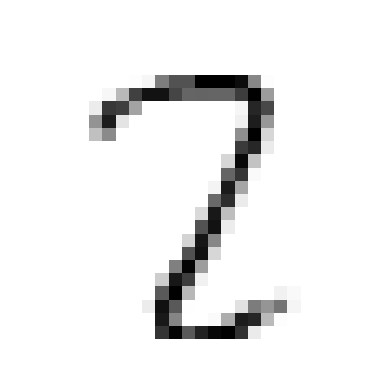

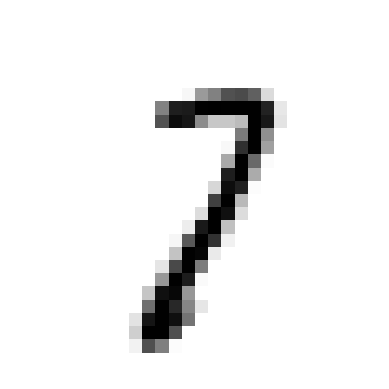

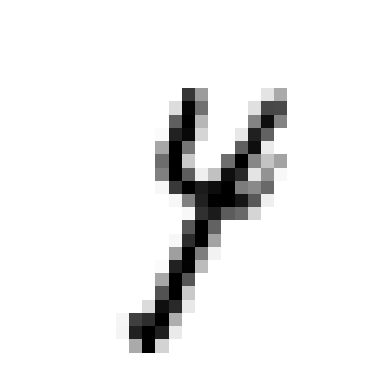

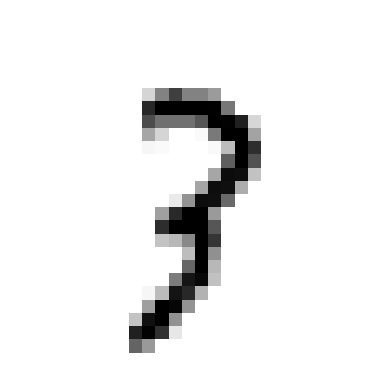

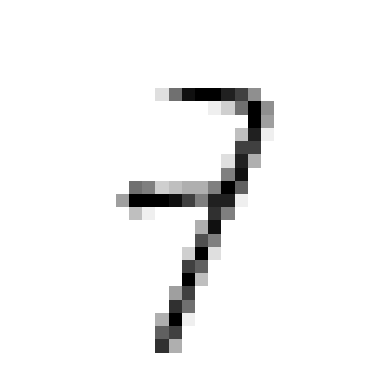

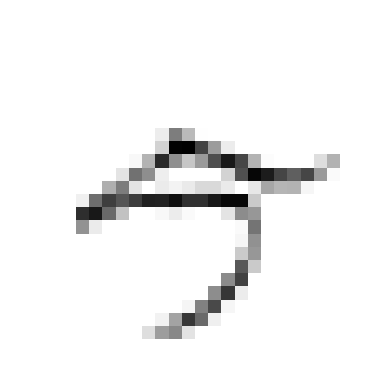

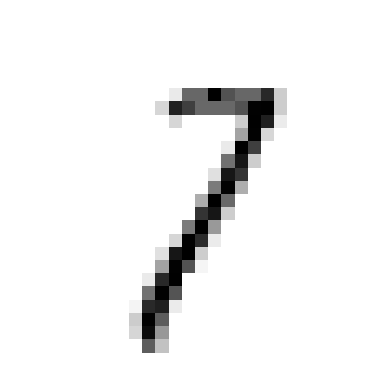

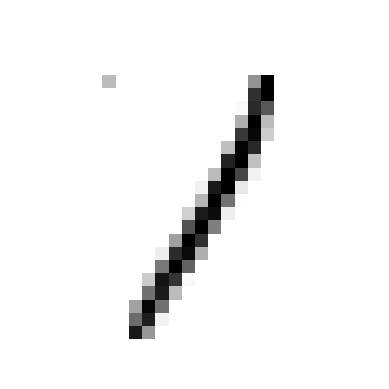

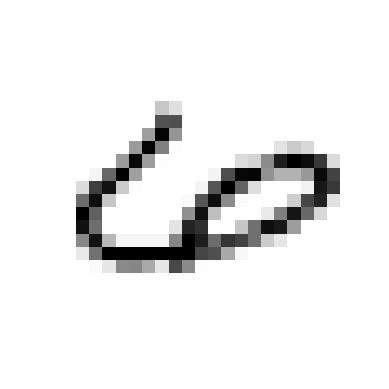

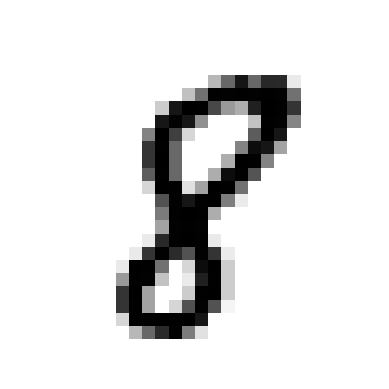

In [24]:
# Plot single digit instance without the border.
# 7
img_indices = [2, 5292, 1462, 5100, 3977, 626]
# 4
img_indices = [2, 16, 5815, 2458, 2581]
# alternative paths
# img_indices = [6326, 2019, 2857, 6684]
img_indices = [1614, 7770, 7350, 8012, 1088, 778, 5650, 1031, 9676, 3003]

for img_idx in img_indices:
    digit1 = np.array(X.iloc[img_idx, :])
    fig, ax = plt.subplots()
    ax.set_axis_off()
    ax.imshow(digit1.reshape(28,28), cmap=plt.cm.gray_r, interpolation=None)
    os.makedirs('figures', exist_ok=True)
    plt.savefig(f'figures/digit_id_{img_idx}.pdf', dpi=300)